# Projeto 3 — Classificação

### Giovana Daniele da Silva

Nº USP: 10692224

email: giovana.daniele@usp.br

github: http://github.com/giovanadanieles



### Renan de Oliveira da Cruz

Nº USP: 10801090 

email: r_oliveira@usp.br

github: http://github.com/nan-oliveira

In [2]:
# Bibliotecas utilizadas

import seaborn as sns
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, f1_score, precision_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import StratifiedKFold, KFold
import sklearn.metrics
import math
from sklearn.ensemble import RandomForestClassifier
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# fixando semente
np.random.seed(21)

A seguir os classificadores Naive Bayes, Paramétrico e Não Paramétrico serão definidos.

In [ ]:
# Classificador Naive Bayes
def clas_naive_bayes(X, y, p = 0.8):
  # armazena os nomes das classes
  classes = np.array(pd.unique(y), dtype=float)

  # dividindo o dataset em trinamento e teste
  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = p, random_state = 42)

  # Z sera o X de treinamento e o y será o ponto em que a verossimilhança será avaliada (x de teste)
  def likelyhood(y, Z):
    def gaussian(x, mu, sig):
        return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))
    prob = 1
    for j in np.arange(0, Z.shape[1]):
        m = np.mean(Z[:,j])
        s = np.std(Z[:,j])      
        prob = prob*gaussian(y[j], m, s)
    return prob

  # Matriz que armazena as probabilidades para cada classe
  P = pd.DataFrame(data=np.zeros((X_test.shape[0], len(classes))), columns = classes) 
  
  for i in np.arange(0, len(classes)):
      elements = tuple(np.where(y_train == classes[i]))
      Z = X_train[elements,:][0]
      for j in np.arange(0,X_test.shape[0]):
          x = X_test[j,:]
          pj = likelyhood(x,Z)
          P[classes[i]][j] = pj*len(elements[0])/X_train.shape[0]

  y_pred = []
  for i in np.arange(0, P.shape[0]):
      c = np.argmax(np.array(P.iloc[[i]]))
      y_pred.append(P.columns[c])
  y_pred = np.array(y_pred, dtype=float)

  score = accuracy_score(y_pred, y_test)

  return score


# Classificador paramétrico
def clas_bayesiano_parametrico(X, y, p = 0.8):
  # armazena os nomes das classes
  classes = np.array(pd.unique(y), dtype=float)

  # dividindo o dataset em trinamento e teste
  x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = p, random_state = 42)

  # matrix para armazenar as probabilidades
  P = pd.DataFrame(data = np.zeros((x_test.shape[0], len(classes))), columns = classes) 

  Pc = np.zeros(len(classes)) # probabilidade de pertencer a cada classe
  for i in np.arange(0, len(classes)):
      elements = tuple(np.where(y_train == classes[i]))
      Pc[i] = len(elements[0])/len(y_train)
      Z = x_train[elements,:][0]
      m = np.mean(Z, axis = 0)
      cv = np.cov(np.transpose(Z))
      for j in np.arange(0,x_test.shape[0]):
          x = x_test[j,:]
          pj = multivariate_normal.pdf(x, mean=m, cov=cv, allow_singular=True)
          P[classes[i]][j] = pj*Pc[i]

  y_pred = [] # Vetor com as classes preditas
  for i in np.arange(0, x_test.shape[0]):
      c = np.argmax(np.array(P.iloc[[i]]))
      y_pred.append(classes[c])
  y_pred = np.array(y_pred, dtype=float)
  # calcula a acuracia
  score = accuracy_score(y_pred, y_test)

  return score


# Classificador não paramétrico
def clas_bayesiano_N_parametrico(X, y, p = 0.8, h = 2):
  # armazena os nomes das classes
  classes = np.array(pd.unique(y), dtype=float)  

  # Seleciona os conjuntos de treinamento e teste
  x_train, x_test, y_train, y_test = train_test_split(X, y, train_size = p, random_state = 42)

  # Matriz que armazena as probabilidades para cada classe
  P = pd.DataFrame(data=np.zeros((x_test.shape[0], len(classes))), columns = classes) 
  Pc = np.zeros(len(classes)) # Armazena a fracao de elementos em cada classe

  for i in np.arange(0, len(classes)): # Para cada classe
      elements = tuple(np.where(y_train == classes[i])) # elementos na classe i
      Pc[i] = len(elements[0])/len(y_train) # Probabilidade pertencer a classe i
      Z = x_train[elements,:][0] # Elementos no conjunto de treinamento
      kde = KernelDensity(kernel='gaussian', bandwidth=h).fit(Z)
      for j in np.arange(0,x_test.shape[0]): # para cada observacao no conjunto de teste
          x = x_test[j,:]
          x = x.reshape((1,len(x)))
          # calcula a probabilidade pertencer a cada classe
          pj = np.exp(kde.score_samples(x)) 
          P[classes[i]][j] = pj*Pc[i]
          
  y_pred = [] # Vetor com as classes preditas
  for i in np.arange(0, x_test.shape[0]):
      c = np.argmax(np.array(P.iloc[[i]]))
      y_pred.append(classes[c])
  y_pred = np.array(y_pred, dtype=float)
  # calcula a acuracia
  score = accuracy_score(y_pred, y_test)

  return score

###1) Considere a base de dados sobre [performance de estudantes em provas](https://www.kaggle.com/spscientist/students-performance-in-exams/discussion). Faça o pré-processamento dos dados e classifique os alunos de acordo com a variável “sexo”.  Considere os classificadores: Bayesiano paramétrico, Bayesiano não-paramétrico e Naive Bayes.

Leitura dos dados:

In [4]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# Carregando os dados em um objeto
data_students = pd.read_csv("/content/drive/Shareddrives/Introdução à Ciência de Dados/Projeto 3/Dados/studentsPerformance.csv")

Mounted at /content/drive/


Visualizando dados e garantindo que os mesmos foram corretamente carregados no dataframe:

In [ ]:
data_students.head()

gender race/ethnicity  ... reading score writing score
0  female        group B  ...            72            74
1  female        group C  ...            90            88
2  female        group B  ...            95            93
3    male        group A  ...            57            44
4    male        group C  ...            78            75

[5 rows x 8 columns]

A seguir, verifica-se se os dados necessitam de algum tipo de limpeza (como remoção de NaN e de símbolos externos, como '?'). 

In [ ]:
print(data_students.shape)

data_students.info()

(1000, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


Como observado acima, a limpeza não é necessária. 

Feito isso, o objetivo da presente análise é classificar o sexo do estudante de duas maneiras distintas: primeiro com base nas covariáveis *gender*, *race/ethnicity*, *parental level of education*, *lunch*, *test preparation course*, *math score*,	*reading score* e *writing score*; depois com base nas covariáveis  *math score*,	*reading score* e *writing score* apenas. 

É interessante, então, fazer uma análise geral dos dados, de forma a obter *insights* de sua distribuição e da correlação dos atributos, como feito a seguir.

Abaixo constam gráficos com a estimativa da densidade das covariáveis, juntamente com o coeficiente de correlação de Pearson.

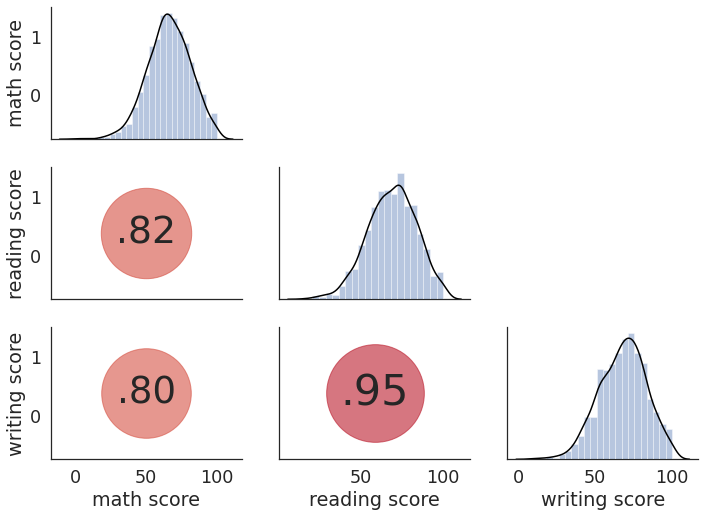

In [ ]:
# Função responsável por incluir o coeficiente de correlação de Pearson no triângulo
#superior do gráfico
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)
    

# Função responsável por ocultar o grid do triângulo superior do gráfico 
def hide_current_axis(*args, **kwds):
    plt.gca().set_visible(False)


# Gerando o gráfico em si
sns.set(style='white', font_scale=1.6)
g = sns.PairGrid(data_students, aspect=1.4, diag_sharey=False).set(ylim=(-0.75, 1.5))
g.map_lower(corrdot)
g.map_diag(sns.distplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)
g.map_upper(hide_current_axis)

plt.show()

Como é possível observar, todos os três atributos numéricos são fortemente correlacionados, principalmente *reading score* e *writing score*, que apresentam correlação de Pearson $0.95$. Além disso, também é possível observar que as distribuições dos três atributos são similares e aparentam ser simétricas. 


Agora, as classes nominais (*gender*, *race/ethnicity*, *parental level of education*, *lunch* e *test preparation course*) serão convertidas em inteiros para possibilitar o processamento. Isso é, a classe *gender*, por exemplo, deixará de ser *male* e *female* e se tornará $0$ e $1$. 

In [ ]:
for j in range(0, 5):
  # Recolhendo as classes
  classes = np.unique(data_students[data_students.columns[j]])

  number = 0 # Valor que será usado para representar a classes
  for i in classes:
      data_students = data_students.replace(i, number) # substitui cada valor da classe por number
      number = number + 1

data_students.head(5)

gender  race/ethnicity  ...  reading score  writing score
0       0               1  ...             72             74
1       0               2  ...             90             88
2       0               1  ...             95             93
3       1               0  ...             57             44
4       1               2  ...             78             75

[5 rows x 8 columns]

É importante, ainda, verificar o balanceamento do conjunto de dados, como feito a seguir.

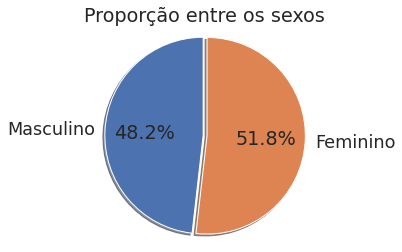

In [ ]:
labels = ["Masculino", "Feminino"]
size = [sum(data_students.iloc[:, 0] == 1), sum(data_students.iloc[:, 0] == 0)]
explode = [0.02, 0.02]

fig, ax1 = plt.subplots()

ax1.pie(size, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis("equal")
plt.title("Proporção entre os sexos")
plt.show()

Como observado no gráfico acima, os dados estão balanceados (isto é, as proporções de masculino e femino são próximas).

Também será analisado, através do gráfico a seguir, a separação existente nos dados (numéricos), quando estratificados pelo gênero.

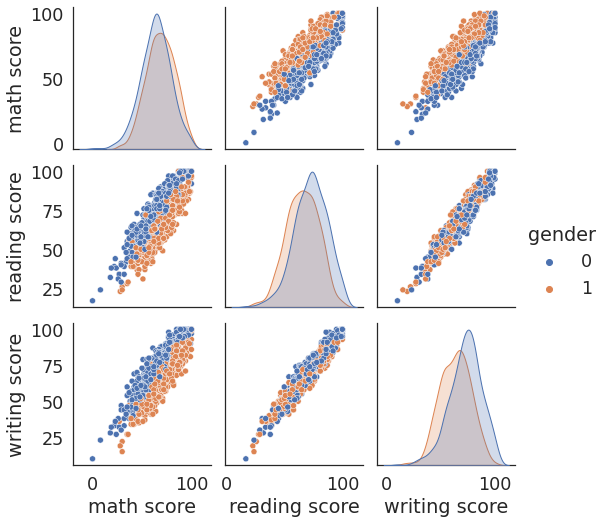

In [ ]:
# Criando um dataset que armazene apenas o target e os 3 últimos atributos
data_students_only3 = data_students.loc[:, ["gender", "math score",	"reading score", "writing score"]]

# Plotando
sns.pairplot(data_students_only3, hue = 'gender')
plt.show()

É possível perceber, mediante os gráficos de dispersão acima, que para os diferentes atributos os valores relacionados a masculino tendem a ficar próximos. O mesmo ocorre para as observações relacionadas ao sexo feminino.

Como não se observou a necessidade de limpeza e, ainda, nos gráficos de dispersão, não identificou-se nenhum ponto discrepante, os dados serão apenas normalizados no intervalo $[0, 1]$ a seguir.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Preparando a função para transformar os dados
scaler = MinMaxScaler(feature_range=(0, 1))
                            
# Salvando em um vetor os valores normalizados                           
norm = scaler.fit_transform(data_students[['math score', 'reading score', 'writing score']])

# Passando os valores do vetor para os dataframes
data_students.iloc[:, 0] = pd.DataFrame({'gender': data_students['gender']})
data_students.iloc[:, 5:8] = pd.DataFrame({'math score': norm[:, 0], 'reading score': norm[:, 1], 'writing score': norm[:, 2]})

data_students_only3.iloc[:, 0:4] = pd.DataFrame({'gender': data_students_only3['gender'], 'math score': norm[:, 0], 'reading score': norm[:, 1], 'writing score': norm[:, 2]})

data_students.head(5)

gender  race/ethnicity  ...  reading score  writing score
0       0               1  ...       0.662651       0.711111
1       0               2  ...       0.879518       0.866667
2       0               1  ...       0.939759       0.922222
3       1               0  ...       0.481928       0.377778
4       1               2  ...       0.734940       0.722222

[5 rows x 8 columns]

#### Primeira análise: baseada em todos os atributos existentes

Separando as classes ($y$) e os demais atributos ($x$):

In [ ]:
# Salvando os dados também em um vetor
data_students_norm_vec = data_students.to_numpy()

# Armazenando dimensões
nrow, ncol = data_students_norm_vec.shape

# Vetor com as classes
y_norm = data_students_norm_vec[:,0]

# Vetor com os demais atributos
x_norm = data_students_norm_vec[:,1:ncol]

print(x_norm)

[[1.         1.         1.         ... 0.72       0.6626506  0.71111111]
 [2.         4.         1.         ... 0.69       0.87951807 0.86666667]
 [1.         3.         1.         ... 0.9        0.93975904 0.92222222]
 ...
 [2.         2.         0.         ... 0.59       0.65060241 0.61111111]
 [3.         4.         1.         ... 0.68       0.73493976 0.74444444]
 [3.         4.         0.         ... 0.77       0.8313253  0.84444444]]


Verificando qual o melhor $h$ para o classificador não paramétrico:

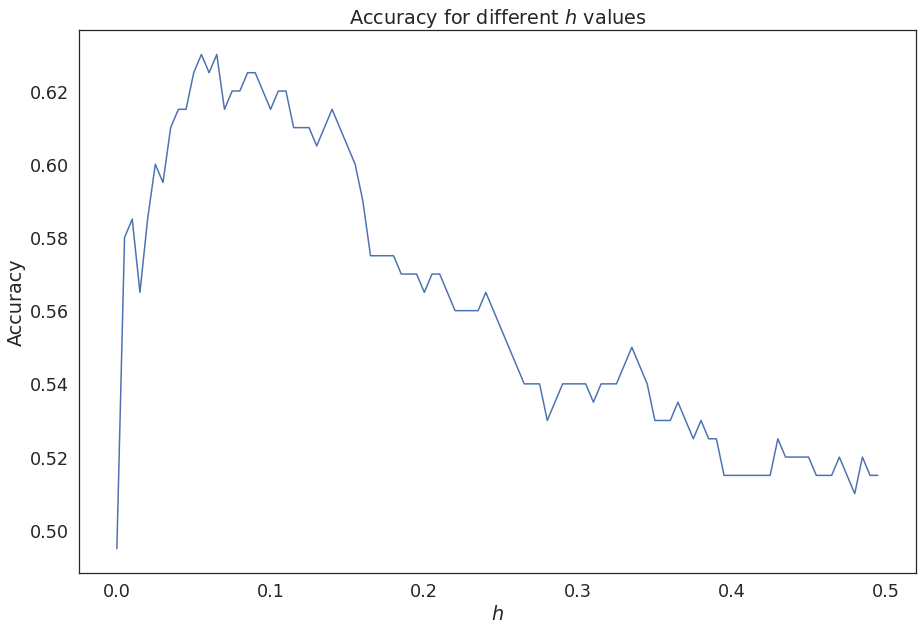

In [ ]:
# Criando uma cópia
X = x_norm.copy()
y = y_norm.copy()

# Definindo diferentes valores para h
h_values = np.arange(0.000005, 0.5, 0.005)

# Dataframe que guardará as acurácias e o respectivo valor de h
dados_ac = pd.DataFrame(data = np.zeros((len(h_values), 2)), columns = ['Accuracy', 'h']) 

k = 0
for h in h_values: # para cada valor de h
  dados_ac['Accuracy'][k] = clas_bayesiano_N_parametrico(X, y, h = h)
  dados_ac['h'][k] = h

  k = k + 1

plt.figure(figsize=(15,10))

# Plotando a acurácia para os diferentes valores de h
plt.plot('h', 'Accuracy', data = dados_ac)
plt.xlabel('$h$')
plt.ylabel('Accuracy')
plt.title('Accuracy for different $h$ values')

plt.show()

Capturando o melhor valor de $h$:

In [ ]:
# valor de h que maximiza a acurácia
h_max = dados_ac.iloc[np.where(dados_ac.Accuracy == max(dados_ac.Accuracy))].iloc[0,1]

dados_ac.iloc[np.where(dados_ac.Accuracy == max(dados_ac.Accuracy))].head()

Accuracy         h
11      0.63  0.055005
13      0.63  0.065005

Classificação dos dados através dos três classificadores (e, para o classificador Bayesiano Não Paramétrico, utilizando melhor $h$ obtido):

In [ ]:
classifiers = ['Parametric', 'Nonparametric', 'Naive_Bayes']

# dataframe que guardará as acurácias e as informações daquela acurácia (classificar e ruído) 
dados = pd.DataFrame(data=np.zeros((len(classifiers) * 2, 2)), columns = ['Accuracy', 'Method']) 

# Criando uma cópia dos dados para manter a referência
X = x_norm
y = y_norm

k = 0
for clas in classifiers: # e cálculo a acurácia para os três classificadores
    dados['Method'][k] = clas

    if clas == 'Parametric':
      dados['Accuracy'][k] = clas_bayesiano_parametrico(X, y)
    elif clas == 'Nonparametric':
      dados['Accuracy'][k] = clas_bayesiano_N_parametrico(X, y, h = h_max)
    else:
      dados['Accuracy'][k] = clas_naive_bayes(X, y) 

    k += 1

dados.head(3)

Accuracy         Method
0     0.915     Parametric
1     0.630  Nonparametric
2     0.640    Naive_Bayes

Nota-se que o classificador paramétrico foi o melhor, segundo a acurácia. Além disso, vê-se que o Naive Bayes e o Não paramétrico foram os piores modelos, segundo a mesma métrica. O fato do Naive Bayes não ter sido satisfatório provavelmente se deve à presença de forte correlação entre alguns atributos.

Além disso, nota-se que a transformação de dados categóricos em dados numéricos (da maneira específica que foi feita, sem *one hot encoding*) não é a melhor abordagem possível para o problema. 

#### Segunda análise: baseada em $3$ atributos apenas

Separando as classes ($y$) e os demais atributos ($x$):

In [ ]:
# Salvando os dados também em um vetor
data_students_only3_norm_vec = data_students_only3.to_numpy()

# Armazenando dimensões
nrow, ncol = data_students_only3_norm_vec.shape

# Vetor com as classes
y_norm = data_students_only3_norm_vec[:,0]

# Vetor com os demais atributos
x_norm = data_students_only3_norm_vec[:, [1,2,3]]

print(x_norm)

[[0.72       0.6626506  0.71111111]
 [0.69       0.87951807 0.86666667]
 [0.9        0.93975904 0.92222222]
 ...
 [0.59       0.65060241 0.61111111]
 [0.68       0.73493976 0.74444444]
 [0.77       0.8313253  0.84444444]]


Verificando graficamente qual o melhor $h$ para o classificador não paramétrico:

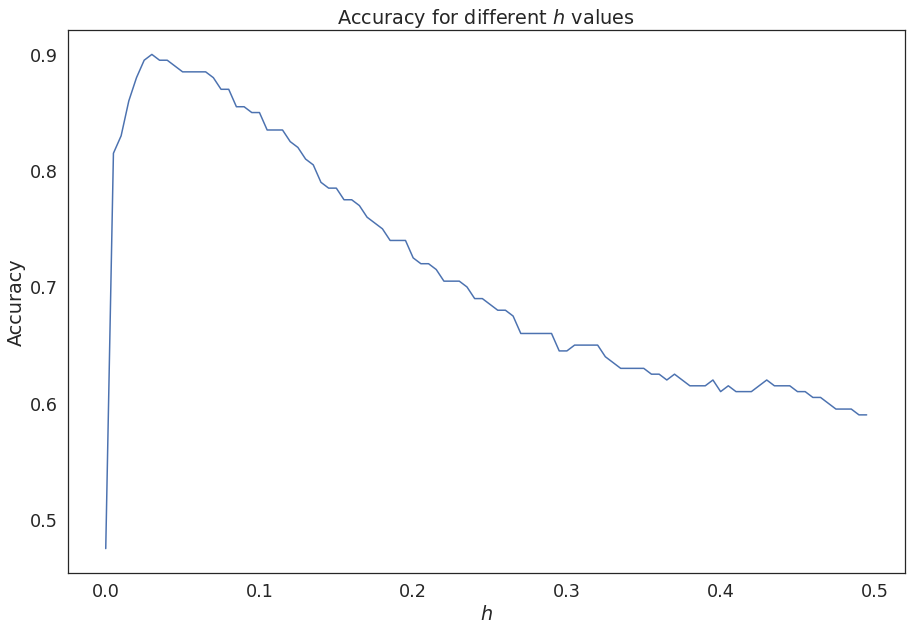

In [ ]:
# Criando uma cópia
X = x_norm.copy()
y = y_norm.copy()

# Definindo diferentes valores para h
h_values = np.arange(0.000005, 0.5, 0.005)

# Dataframe que guardará as acurácias e o respectivo valor de h
dados_ac = pd.DataFrame(data=np.zeros((len(h_values), 2)), columns = ['Accuracy', 'h']) 

k = 0
for h in h_values: # para cada valor de h
  dados_ac['Accuracy'][k] = clas_bayesiano_N_parametrico(X, y, h = h)
  dados_ac['h'][k] = h

  k = k + 1

plt.figure(figsize=(15,10))

# Plotando a acurácia para os diferentes valores de h
plt.plot('h', 'Accuracy', data = dados_ac)
plt.xlabel('$h$')
plt.ylabel('Accuracy')
plt.title('Accuracy for different $h$ values')

plt.show()

Capturando o melhor valor de $h$:

In [ ]:
# Valor de h que maximiza a acurácia
h_max = dados_ac.iloc[np.where(dados_ac.Accuracy == max(dados_ac.Accuracy))].iloc[0,1]

dados_ac.iloc[np.where(dados_ac.Accuracy == max(dados_ac.Accuracy))].head()

Accuracy         h
6       0.9  0.030005

Classificação dos dados através dos três classificadores:

In [ ]:
classifiers = ['Parametric', 'Nonparametric', 'Naive_Bayes']

# dataframe que guardará as acurácias e as informações daquela acurácia (classificar e ruído) 
dados = pd.DataFrame(data=np.zeros((len(classifiers) * 2, 2)), columns = ['Accuracy', 'Method']) 

# Criando uma cópia dos dados para manter a referência
X = x_norm
y = y_norm

k = 0
for clas in classifiers: # e cálculo a acurácia para os três classificadores
    dados['Method'][k] = clas

    if clas == 'Parametric':
      dados['Accuracy'][k] = clas_bayesiano_parametrico(X, y)
    elif clas == 'Nonparametric':
      dados['Accuracy'][k] = clas_bayesiano_N_parametrico(X, y, h = h_max)
    else:
      dados['Accuracy'][k] = clas_naive_bayes(X, y) 

    k += 1

dados.head(3)

Accuracy         Method
0     0.895     Parametric
1     0.900  Nonparametric
2     0.645    Naive_Bayes

Assim como anteriormente, Naive Bayes foi o pior modelo, o que se deve, provavelmente, à forte correlação entre os atributos. Além disso, para esse caso, o classificador Não Paramétrico foi o melhor, o que se deve ao fato de que, retirando-se os atributos categóricos, o Kernel se ajustar melhor aos dados.

###2) No classificar não-paramétrico, verifique o efeito do hiperparâmetro $h$ na classificação dos dados de diabetes, encontrando seu melhor valor ([dataset](https://www.kaggle.com/uciml/pima-indians-diabetes-database)).

Carregando os dados:

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

# Carregando os dados em um objeto
data_diabetes = pd.read_csv("/content/drive/Shareddrives/Introdução à Ciência de Dados/Projeto 3/Dados/diabetes.csv")

print(data_diabetes.shape)

data_diabetes.info()

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
(768, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


Exibindo os dados e verificando se houve algum erro no salvamento dos mesmos no dataframe:

In [ ]:
data_diabetes.head()

Pregnancies  Glucose  BloodPressure  ...  DiabetesPedigreeFunction  Age  Outcome
0            6      148             72  ...                     0.627   50        1
1            1       85             66  ...                     0.351   31        0
2            8      183             64  ...                     0.672   32        1
3            1       89             66  ...                     0.167   21        0
4            0      137             40  ...                     2.288   33        1

[5 rows x 9 columns]

Como a base de dados não apresentou nenhum valor faltante ou valores destoantes da realidade (como '?' ou 'inf'), não houve limpeza a se fazer.

A seguir a distribuição dos atributos será exprimida através de gráficos, de forma a fornecer uma visão geral (macro) dos dados.

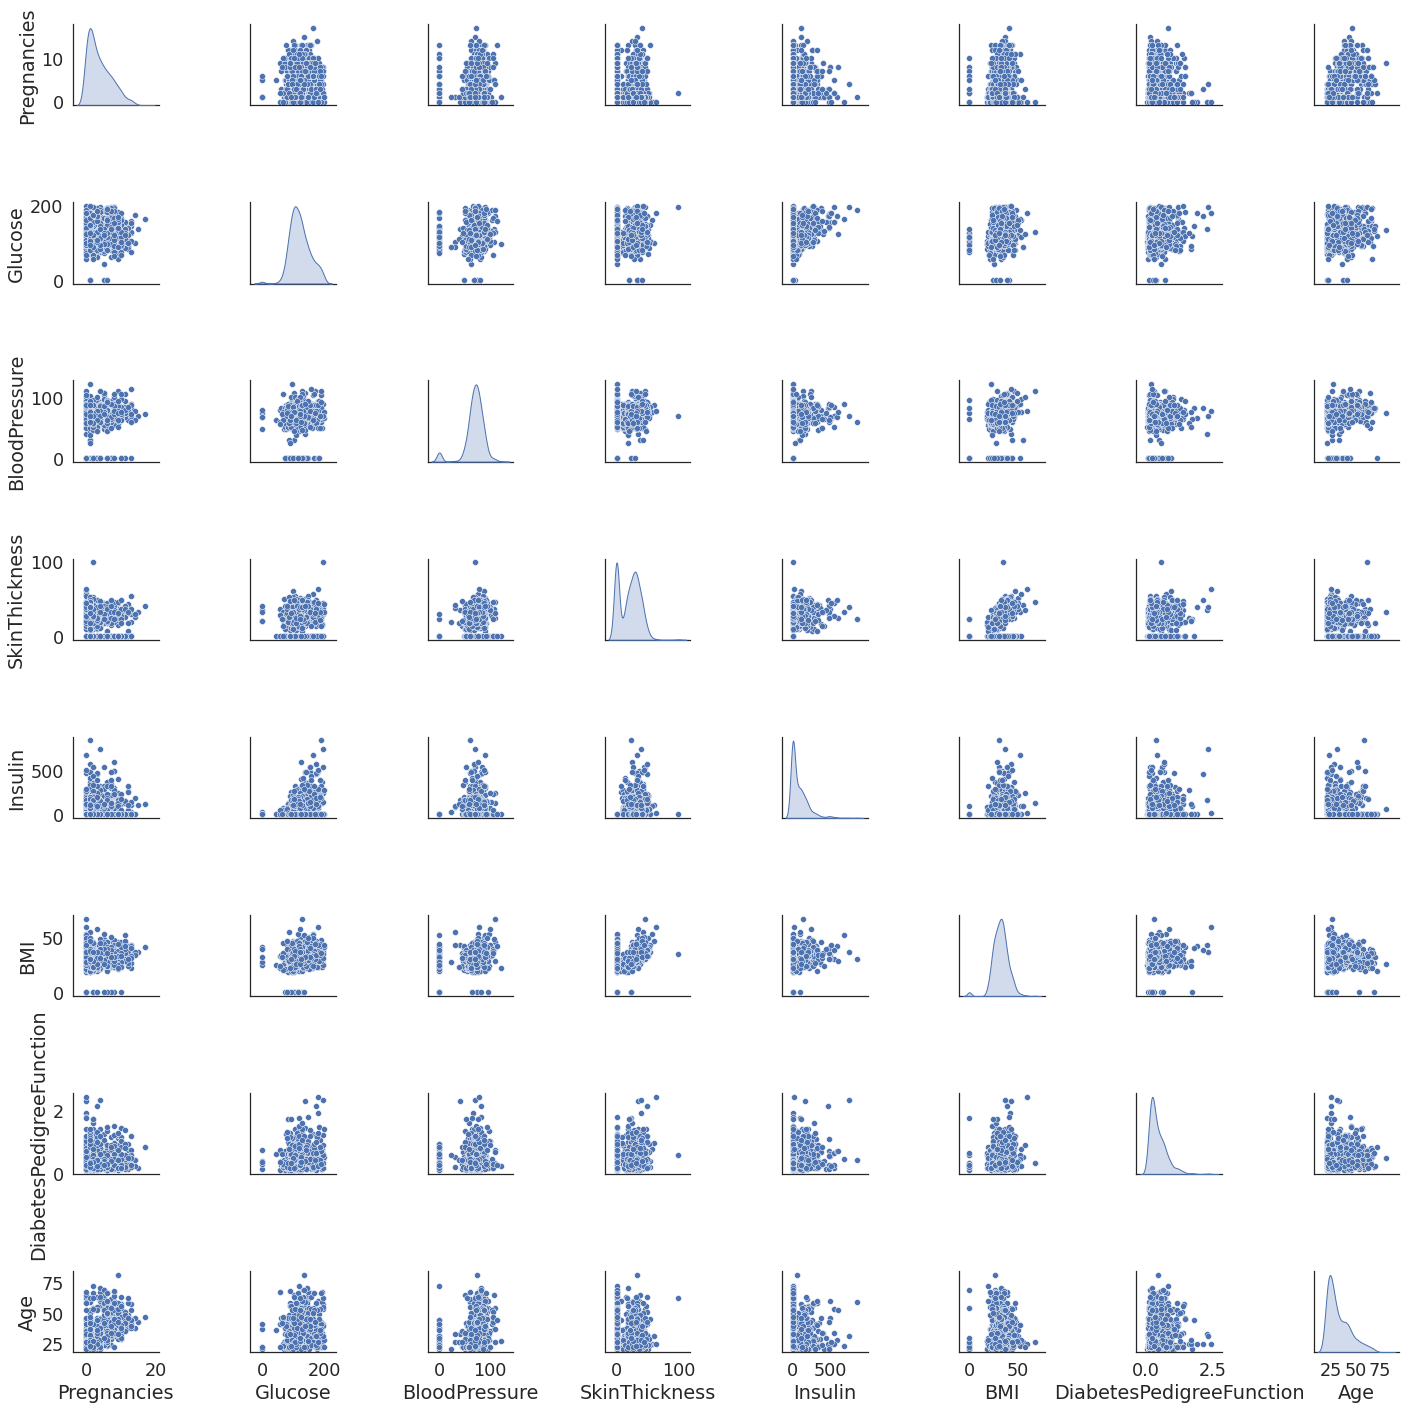

In [ ]:
import seaborn as sns

sns.pairplot(data_diabetes.drop(columns='Outcome'), diag_kind='kde')
plt.show()

No gráfico acima, "marginalmente", nenhum atributo aparenta ser fortemente correlacionado com outro. Além disso, a partir da diagonal principal é possível notar que as distribuições dos atributos, a menos de escala, são semelhantes -- com exceção do atributo *SkinThickness*, que apresenta distribuição bimodal.

Partindo, portanto, para a normalização, tem-se:

In [ ]:
# Neste trecho de código três tarefas principais serão efetuadas:
#    1. As classes (target) serão salvas em y
#    2. Os demais atributos (com exceção da classe) serão salvos em x
#    3. Os dados em x serão normalizados

from sklearn.preprocessing import MinMaxScaler

# Transformando o dataframe em vetor
data_diabetes_vec = data_diabetes.to_numpy()

# Armazenando dimensões
nrow, ncol = data_diabetes_vec.shape

# Vetor com as classes
y = data_diabetes_vec[:,-1]

# Vetor com os demais atributos
x = data_diabetes_vec[:,0:ncol-1]

# Preparando a função para transformar os dados
scaler = MinMaxScaler(feature_range=(0, 1))

# Realizando a normalização e colocando em um vetor
x_norm = scaler.fit_transform(x)

print(x_norm.shape)
print()
print(x_norm)

(768, 8)

[[0.35294118 0.74371859 0.59016393 ... 0.50074516 0.23441503 0.48333333]
 [0.05882353 0.42713568 0.54098361 ... 0.39642325 0.11656704 0.16666667]
 [0.47058824 0.91959799 0.52459016 ... 0.34724292 0.25362938 0.18333333]
 ...
 [0.29411765 0.6080402  0.59016393 ... 0.390462   0.07130658 0.15      ]
 [0.05882353 0.63316583 0.49180328 ... 0.4485842  0.11571307 0.43333333]
 [0.05882353 0.46733668 0.57377049 ... 0.45305514 0.10119556 0.03333333]]


In [ ]:
print('Mínimo dos atributos:', np.amin(x_norm, axis=0))
print('Máximo dos atributos:', np.amax(x_norm, axis=0))

Mínimo dos atributos: [0. 0. 0. 0. 0. 0. 0. 0.]
Máximo dos atributos: [1. 1. 1. 1. 1. 1. 1. 1.]


Variando os valores de $h$ para o modelo:

In [ ]:
# Criando uma copia dos valores originais
X = x_norm.copy()
y = y.copy()


# Definindo diferentes valores para h
h_values = np.arange(0.005, 0.4, 0.005)

# Dataframe que guardará as acurácias e o respectivo valor de h
dados = pd.DataFrame(data=np.zeros((len(h_values), 2)), columns = ['Accuracy', 'h']) 

k = 0
for h in h_values: # para cada valor de h
  dados['Accuracy'][k] = clas_bayesiano_N_parametrico(X, y, h = h)
  dados['h'][k] = h

  k = k + 1

Criando gráfico para melhor visualização:

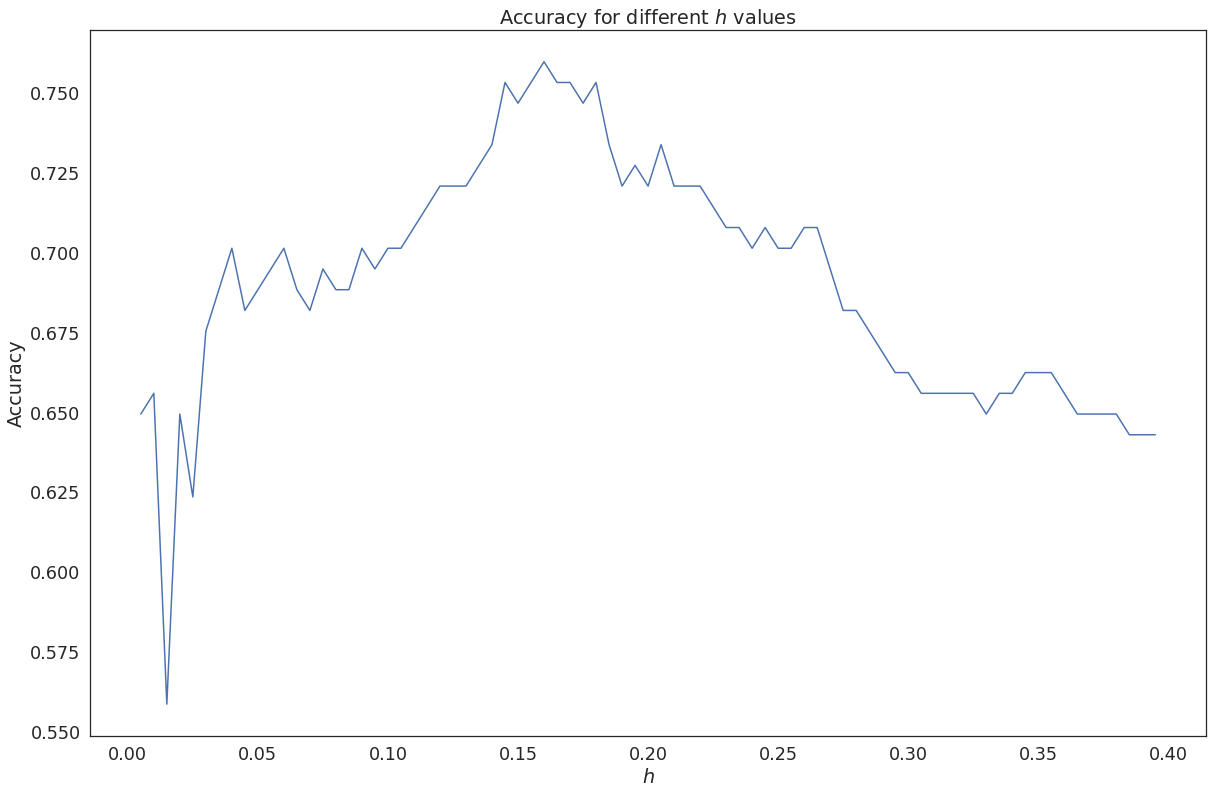

In [ ]:
plt.figure(figsize=(20,13))

# Plotando a acurácia para os diferentes valores de h
plt.plot('h', 'Accuracy', data = dados)
plt.xlabel('$h$')
plt.ylabel('Accuracy')
plt.title('Accuracy for different $h$ values')

plt.show()

Selecionando a maior acurácia e verificando qual é o respectivo $h$:

In [ ]:
# Valor de h que maximiza a acurácia
h_max = dados.iloc[np.where(dados.Accuracy == max(dados.Accuracy))].iloc[0,1]

dados.iloc[np.where(dados.Accuracy == max(dados.Accuracy))].head()

Accuracy     h
31   0.75974  0.16

Por fim, como é possível observar, no intervalo $[0, 0.16]$ tem-se uma tendência de aumento dos valores da acurácia. Já no intervalo $[0.16, 0.4]$ a tendência é de decrescimento. Ainda, a maior acurácia ($0.75974$) é obtida para $h = 0.16$.

###3) Considere o código abaixo para gerar dados artificialmente.

```
from sklearn import datasets
import matplotlib.pyplot as plt
plt.figure(figsize=(6,4))
n_samples = 1000
data = datasets.make_moons(n_samples=n_samples, noise=.05)
X = data[0]
y = data[1]
plt.scatter(X[:,0], X[:,1], c=y, cmap=’viridis’, s=50, alpha=0.7)
plt.show(True)
```

###Compare os resultados para os métodos Naive Bayes, Classificador Bayesiano paramétrico e o classificador Bayesiano não-paramétrico, variando o ruído (*noise*).

Tem-se abaixo o código apresentado no enunciado:

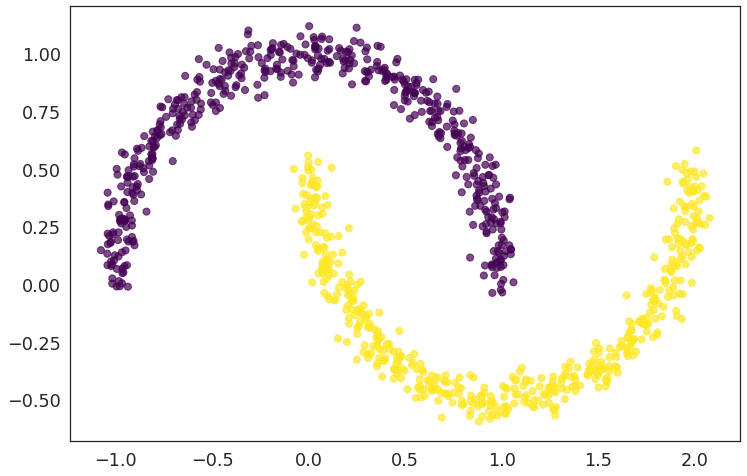

In [ ]:
from sklearn import datasets
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))

n_samples = 1000

data = datasets.make_moons(n_samples=n_samples, noise=.05)

X = data[0]
y = data[1]

plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50, alpha=0.7)
plt.show(True)

Por meio da figura acima, nota-se que os dados correspondentes às variáveis independentes estão ''distantes'' uns dos outros para as diferentes classes. Isto é, quando $y = 0$, tem-se um padrão dos atributos diferente de quando $y = 1$ (em um caso encontra-se um nuvem de pontos que apresenta uma forma de arco com concavidade para baixo, enquanto que no outro se tem uma nuvem que pontos que visuamente se assemelha a um arco com concavidade para cima). Além disso, esses dois arcos estão distantes e não possuem "pontos em uma mesma região".



Em seguida, apresenta-se uma breve análise dos dados. 

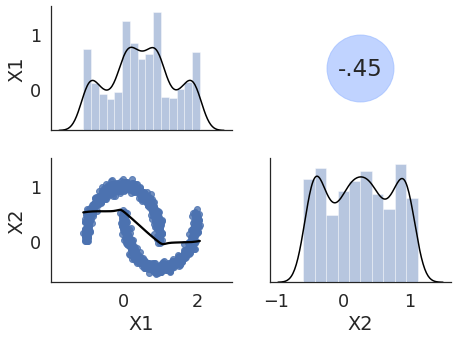

In [ ]:
# Código responsável por incluir o coeficiente de correlação de Pearson no triângulo
#superior do gráfico

def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

# Transformando os dados em dataframe
data = pd.DataFrame()
data['X1'] = X[:,0]
data['X2'] = X[:,1]

# Gerando o gráfico em si
sns.set(style='white', font_scale=1.6)
g = sns.PairGrid(data, aspect=1.4, diag_sharey=False).set(ylim=(-0.75, 1.5))
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
g.map_diag(sns.distplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)

plt.show()

Note que, pelo coeficiente de correlação de Pearson, os atributos $X_1$ e $X_2$ são fracamente correlacionados, todavia, ressalta-se que o coeficiente de Pearson não é indicado para essa situação, pois, conforme é visto no gráfico de dispersão no canto inferior esquerdo, não existe uma relação linear entre $X_1$ e $X_2$.

Além disso, mediante os histogramas da diagonal principal, nota-se que, visualmente, $X_1$ e $X_2$ aparentam não ser normalmente distribuídos. Sabe-se que, se um vetor aleatório tem distribuição normal multivariada, então as variáveis aleatórias marginais serão normalmente distribuídas. Desse modo, tem-se que se as marginais - nesse caso $X_1$ e $X_2$ - não forem normalmente distribuídas, então o vetor aleatório - nesse caso o vetor **X** = $[X_1, X_2]^{T}$-, composto dessas marginais, não terá distribuição normal multivariada.

Por conseguinte, em razão da argumentação supracitada, tem-se que, como as marginais aparentam não ser normalmente distribuídas, há um indicativo de que o vetor aleatório **X** = $[X_1, X_2]^{T}$ não provém de uma população que distribui-se conforme a normal bivariada.

Ainda assim, por critérios de simplificação, assume-se que **X** = $[X_1, X_2]^{T}$ tem distribuição normal bivariada ao utilizar o classificador Paramétrico e o Naive Bayes.

In [ ]:
round(data.describe(), 4)

X1         X2
count  1000.0000  1000.0000
mean      0.4987     0.2505
std       0.8684     0.4948
min      -1.0754    -0.5958
25%      -0.0295    -0.2029
50%       0.4980     0.2611
75%       1.0289     0.7022
max       2.0768     1.1193

Mediante as estatísticas descritivas acima e dos gráficos de dispersão e histograma, optar-se-á pela realização de transformações nas variáveis; os dados serão transformados para o intervalo $[0, 1]$.  

A seguir, serão executados os três classificadores para que se verifique se os mesmos não apresentam problemas.

Executando o classificar bayesiano paramétrico tem-se uma acurácia de 83,5%:

In [ ]:
clas_bayesiano_parametrico(X, y, p = 0.8)

0.835

Executando o classificador bayesiano não paramétrico tem-se uma acurácia de 76,5%. Essa acurácia menor deve ser resultado, provavelmente, da escolha arbitrária de $h$.

In [ ]:
clas_bayesiano_N_parametrico(X, y, p = 0.8, h = 2)

0.765

Executando o classificar naive Bayes tem-se uma acurácia de 84%:

In [ ]:
clas_naive_bayes(X, y)

0.84

Como nenhum classificador apresentou problemas, é necessário abandonar a arbitrariedade e definir com critérios o valor de $h$ para o classificador Bayesiano Não Paramétrico. Como é de desejo realizar uma comparação para diferentes ruídos, o valor de $h$ será defino como sendo o valor que maximiza a acurácia em cada caso.

Seguidamente, calcula-se as acurácias para os diferentes valores de ruído nos diferentes tipos de classificadores.

In [ ]:
# função gera as amotras
def amostras(noise =.05, n_samples = 1000): 
  data = datasets.make_moons(n_samples=n_samples, noise = noise)
  X = data[0]
  y = data[1]
  return [X, y]

def best_h(X, y):
  # Definindo diferentes valores para h
  h_values = np.arange(0.005, 1, 0.005)

  # Dataframe que guardará as acurácias e o respectivo valor de h
  dados_ac = pd.DataFrame(data=np.zeros((len(h_values), 2)), columns = ['Accuracy', 'h']) 

  k = 0
  for h in h_values: # para cada valor de h
    dados_ac['Accuracy'][k] = clas_bayesiano_N_parametrico(X, y, h = h)
    dados_ac['h'][k] = h
    k = k + 1
  h_max = dados_ac.iloc[np.where(dados_ac.Accuracy == max(dados_ac.Accuracy))].iloc[0,1]
  return h_max

# diferentes valores para o ruído
v_noise = [0.05, 0.1, 0.25, 0.5, 0.75, 1.0, 1.5, 2.0, 3.0, 4]

# dataframe que guardará as acurácias e as informações daquela acurácia (classificar e ruído) 
dados = pd.DataFrame(data=np.zeros((len(v_noise) * 3, 3)), columns = ['Accuracy', 'Method', 'Noise']) 
classifiers = ['Parametric', 'Nonparametric', 'Naive_Bayes']

k = 0
for ruido in v_noise: # para cada ruído
  X_s, y = amostras(ruido) # gero uma amostra com esse ruído
  # Prepara a função para transformar (normalizar) os dados
  scaler = MinMaxScaler(feature_range = (0, 1))
  # Realizando a normalização e colocando em um array
  X = scaler.fit_transform(X_s)

  for clas in classifiers: # e cálculo a acurácia para os três classificadores
    dados['Noise'][k] = ruido 
    dados['Method'][k] = clas
    if clas == 'Parametric':
      dados['Accuracy'][k] = clas_bayesiano_parametrico(X, y)
    elif clas == 'Nonparametric':
      # h que maximiza a acuracia
      h = best_h(X, y)      

      dados['Accuracy'][k] = clas_bayesiano_N_parametrico(X, y, h = h)
    else:
      dados['Accuracy'][k] = clas_naive_bayes(X, y) 
    k += 1

print(dados.head())
pd.options.mode.chained_assignment = None

   Accuracy         Method  Noise
0     0.870     Parametric   0.05
1     1.000  Nonparametric   0.05
2     0.875    Naive_Bayes   0.05
3     0.875     Parametric   0.10
4     1.000  Nonparametric   0.10


Tem-se, abaixo, o gráfico comparando os três modelos conforme aumenta-se o ruído nos dados:

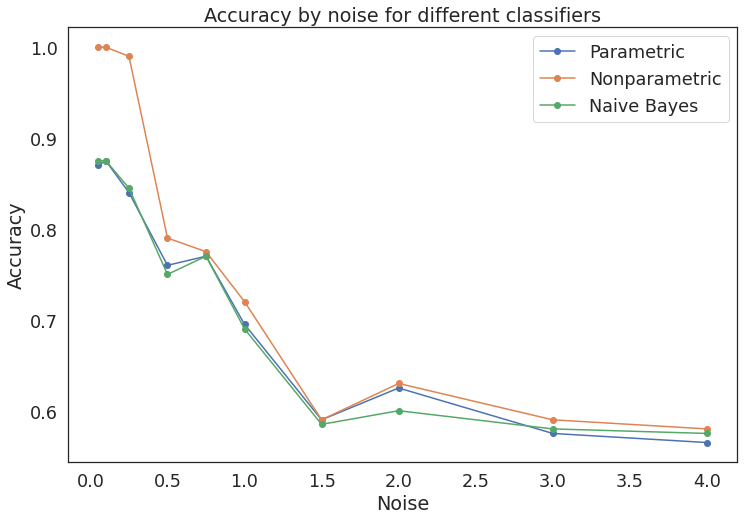

In [ ]:
# Separando por classificador
dados_para = dados[dados.Method == 'Parametric']
dados_npara = dados[dados.Method == 'Nonparametric']
dados_nb = dados[dados.Method == 'Naive_Bayes']

plt.figure(figsize=(12,8))

# Plotando a acurácia por ruído para os diferentes classificadores
plt.plot('Noise', 'Accuracy', marker = 'o', data = dados_para)
plt.plot('Noise', 'Accuracy', marker = 'o', data = dados_npara)
plt.plot('Noise', 'Accuracy', marker = 'o', data = dados_nb)
plt.legend(labels=['Parametric','Nonparametric', 'Naive Bayes'])
plt.xlabel('Noise')
plt.ylabel('Accuracy')
plt.title('Accuracy by noise for different classifiers')
plt.show()

Depreende-se, por intermédio da figura acima que, conforme há um aumento no ruído, o valor da acurácia diminui para todos os classificadores analisados. Ainda, pode-se ver que para baixos ruídos o classificador Não Paramétrico foi levemente superior em relação aos demais. Quando há aumento dos ruídos, tem-se que a performance dos classificadores se assemelham, conquanto ainda seja possível notar uma leve vantagem para o Não Paramétrico.

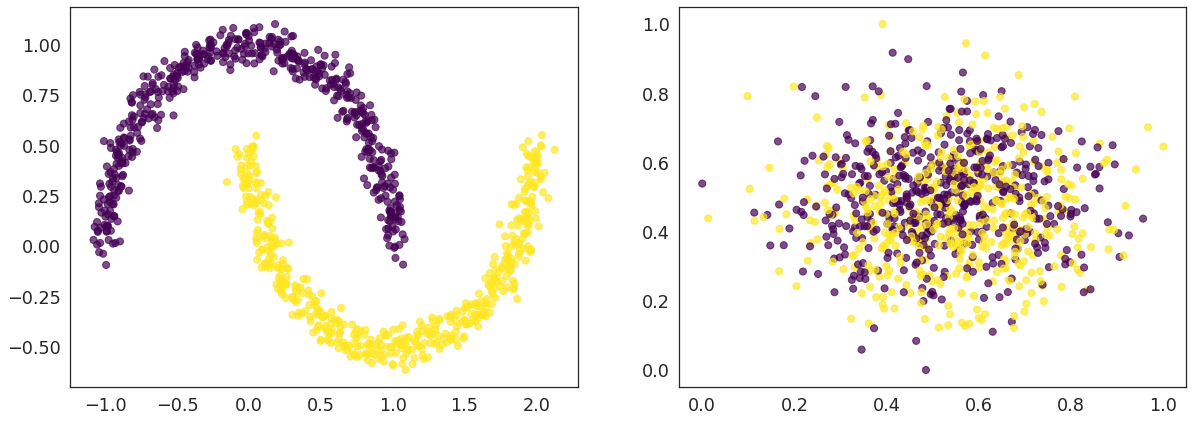

In [ ]:
plt.figure(figsize=(20,7))
plt.subplot(1, 2, 2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50, alpha=0.7)

plt.subplot(1, 2, 1)
data = datasets.make_moons(n_samples=n_samples, noise=.05)

X_aux = data[0]
y_aux = data[1]

plt.scatter(X_aux[:,0], X_aux[:,1], c=y_aux, cmap='viridis', s=50, alpha=0.7)

plt.show(True)

No gráfico da esquerda, dados com um ruído de $0.05$. No gráfico da direita, dados com ruído de $4.0$. 

A razão pela qual esses dois gráficos são exibidos é a evidenciação do motivo da diminuição da acurácia. Quando tem-se dados pouco ruidosos, é possível construir uma região de decisão que possibilita um maior número de acertos na classificação, fato que ocorre na primeira figura. Já na segunda figura, tem-se que os dados possuem muito ruído, o que aumenta o erro associado à classificação; nesse caso, ao constrir a região de decisão, muitos dados estarão no "lugar errado" e, consequentemente, haverá diminuição a acurácia do modelo.

###4) Considerando os dados artificiais do exercício anterior, mostre as regiões de separação para os métodos Naive Bayes, k-vizinhos e regressão logística.

Para esse exercício, optou-se por estudar nove diferentes regiões de separação, referentes às seguintes configurações: 

1. **Naive Bayes** aplicado a uma amostra aleatória de ruído $0.05$,
2. **Naive Bayes** aplicado a uma amostra aleatória de ruído $0.50$,
3. **Naive Bayes** aplicado a uma amostra aleatória de ruído $4.00$,
4. **K-Nearest Neighbors** aplicado a uma amostra aleatória de ruído $0.05$,
5. **K-Nearest Neighbors** aplicado a uma amostra aleatória de ruído $0.50$,
6. **K-Nearest Neighbors** aplicado a uma amostra aleatória de ruído $4.00$,
7. **Regressão Logística** aplicada a uma amostra aleatória de ruído $0.05$,
8. **Regressão Logística** aplicada a uma amostra aleatória de ruído $0.50$,
9. **Regressão Logística** aplicada a uma amostra aleatória de ruído $4.00$.


Com esse objetivo, definir-se-á, a seguir, os classificadores e obter-se-á as amostras aleatórias. Em seguida, com base nos dois, será possível obter os *plots* das regiões de separação.

Definindo classificadores:

In [ ]:
# Definindo os classificadores. Três serão utilizados, como pedido no enunciado:
# Naive Bayes, KNN e Regressão Logística.

from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

# Definindo o classificador Naive Bayes
def class_naive_bayes(x_, y_):
  model = GaussianNB()
  model.fit(x_, y_)

  return model, x_, y_


# Definindo o classificador K-Nearest Neighbors
def class_knn(x_, y_, k = 5):
  model = KNeighborsClassifier(n_neighbors=k, metric = 'euclidean')
  model.fit(x_, y_)

  return model, x_, y_


# Definindo o classificador Regressão Logística
def class_reg_log(x_, y_):
  model = linear_model.LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 1000)
  model.fit(x_, y_)

  return model, x_, y_

Construindo *plots*:

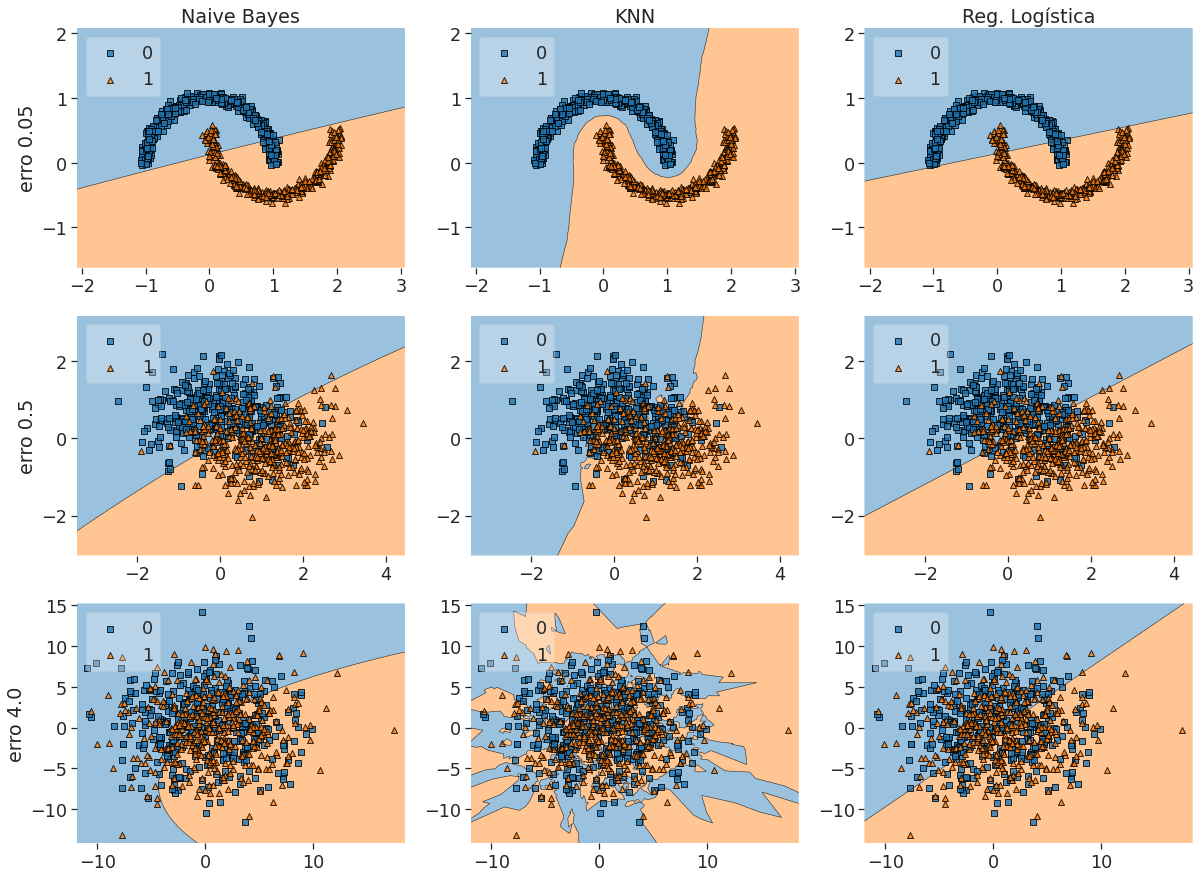

In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Criando as amostras e obtendo os plots de regiões de separação

from sklearn import datasets
from mlxtend.plotting import plot_decision_regions

# Função responsável por gerar as amotras aleatórias
def amostras(noise =.05, n_samples = 1000): 
  data = datasets.make_moons(n_samples=n_samples, noise = noise)
  X = data[0]
  y = data[1]
  return [X, y]

# Definindo três diferentes valores para o ruído
v_noise = [0.05, 0.5, 4]

# Definindo os classificadores que serão utilizados
classifiers = ['Naive_Bayes', 'K_Vizinhos', 'Reg_Logistica']

# Determinando um tamanho para o plot
plt.figure(figsize=(20,15))

k = 0
for ruido in v_noise: # Para cada ruído definido,
  X_amostra, y_amostra = amostras(ruido) # gero uma amostra com esse ruído

  # separo em conjuntos de treino e teste
  from sklearn.model_selection import train_test_split

  X_train, X_test, y_train, y_test = train_test_split(X_amostra, y_amostra, train_size = 0.8)


  for clas in classifiers: # e calculo a acurácia para os três classificadores em questão
    # Posicionando o plot
    plt.subplot(3, 3, k + 1)

    # Definindo uma cópia para não perder os objetos iniciais
    X = X_train
    y = y_train

    # Obtendo os resultados da classificação com o método Naive Bayes e 
    #plotando suas regiões de separação
    if clas == 'Naive_Bayes':
      model, x_, y_ = class_naive_bayes(X, y) 

      # Colocando legendas
      if k + 1 == 1:
        plt.title('Naive Bayes')
        plt.ylabel('erro 0.05')
      if k + 1 == 4:
        plt.ylabel('erro 0.5')
      if k + 1 == 7:
        plt.ylabel('erro 4.0')

      # Plotando
      plot_decision_regions(x_, y_, clf=model, legend=2)

    # Obtendo os resultados da classificação com o método KNN e 
    #plotando suas regiões de separação
    elif clas == 'K_Vizinhos':
      model, x_, y_ = class_knn(X, y)

      # Colocando legendas
      if k + 1 == 2:
        plt.title('KNN')

      # Plotando
      plot_decision_regions(x_, y_, clf=model, legend=2)

    # Obtendo os resultados da classificação com o método Regressão Logística e 
    #plotando suas regiões de separação
    else:
      model, x_, y_ = class_reg_log(X, y) 

      # Colocando legendas
      if k + 1 == 3:
        plt.title('Reg. Logística')

      # Plotando
      plot_decision_regions(x_, y_, clf=model, legend=2)

    k += 1

Como é possível observar nos gráficos acima, a região de decisão da regressão logística é linear, o que, para estes dados em específico, não é uma boa característica, haja vista a forma de separação em "semi arco" apresentada pelos mesmos.

Por outro lado, ainda para o tipo de dados em questão, o modelo de classificasão KNN é relativamente satisfatório, uma vez que a região de decisão associada a esse classificador se adapta bem à estrutura dos dados.

Já o método Naive Bayes é similiar à regressão logística no que tange à região de decisão quando ruídos baixos são considerados. Todavia, pelo gráfico inferior esquedo percebe-se que, ao contrário da regressão logística, a região de decisão do Naive Bayes não é sempre linear. Ressalta-se, ainda, que esse modelo, para esse conjunto de dados, é pior do que o KNN, já que o mesmo não se adapta tão bem quanto o KNN à estrutura dos dados.

Finalmente, salienta-se o fato de que, conforme o ruído aumenta, mais dificil é "criar" uma região de decisão "clara" que possibilite muitos acertos, diminuindo, assim, a acurácia dos modelos.

### 5) Gere dois conjuntos de pontos em duas dimensões usando o código a seguir:

```
from sklearn.datasets import make_blobs
import numpy as np
import matplotlib.pyplot as plt
n = 500
c = [(1,1), (10,10)] #center of the points
std = [5.0, 2] # standard deviation
nc = [400,50] #number of points in each class
X, y = make_blobs(n_samples=n, n_features=2, cluster_std=std,centers= c)
plt.scatter(X[:,0],X[:,1], c=y)
plt.show(True)
```

###Compare os classificadores Naive Bayes e Bayesiano Paramétrico variando a separação entre as nuvens de pontos – mantenha a posição de uma classe fixa e mude a posição do centro da outra classe, calculando a distância entre os centros.

Executando código do enunciado:

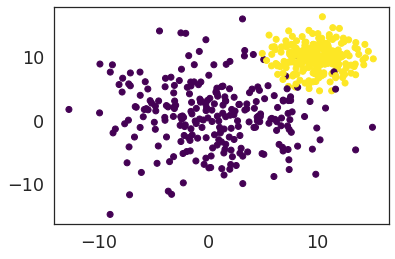

In [ ]:
def sample_values(c = [(1,1), (10,10)]):
  from sklearn.datasets import make_blobs
  import numpy as np
  import matplotlib.pyplot as plt
  n = 500
  # center of the points (definido no argumento da função)
  std = [5.0, 2] # standard deviation
  nc = [400,50] # number of points in each class
  X, y = make_blobs(n_samples=n, n_features=2, cluster_std=std,centers= c)
  return [X, y]

X, y = sample_values([(1,1), (10,10)])
plt.scatter(X[:,0],X[:,1], c=y,  cmap='viridis')
plt.show(True)

Abaixo define-se uma função que retorna a distância euclidiana entre dois pontos.

In [ ]:
def dist_euclidiana(A):
  return np.sqrt((A[0][0] - A[1][0]) ** 2 + (A[0][1] - A[1][1]) ** 2)

Tem-se, em seguida, a construção de três datasets.
A avaliação será performada para 3 diferentes distâncias entre os centros.

Distância entre os centros 16.64331697709324 



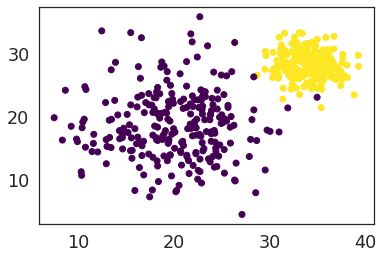


 Distância entre os centros 12.206555615733702 



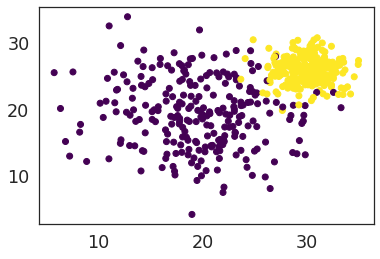


 Distância entre os centros 8.06225774829855 



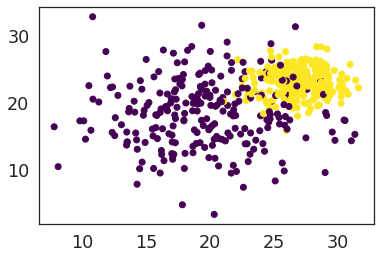

In [ ]:
# dataset 1
C1 = [(20,19), (34,28)] # centro 1
X1, y1 = sample_values(C1)

print("Distância entre os centros", dist_euclidiana(C1), "\n")

plt.scatter(X1[:,0],X1[:,1], c=y1,  cmap='viridis')
plt.show()

# dataset 2
C2 = [(20,19), (30,26)] # centro 2
X2, y2 = sample_values(C2)

print("\n Distância entre os centros", dist_euclidiana(C2), "\n")

plt.scatter(X2[:,0],X2[:,1], c=y2,  cmap='viridis')
plt.show()

# dataset 3
C3 = [(20,19), (27,23)] # centro 3
X3, y3 = sample_values(C3)

print("\n Distância entre os centros", dist_euclidiana(C3), "\n")

plt.scatter(X3[:,0],X3[:,1], c=y3,  cmap='viridis')
plt.show() 

Seguidamente, calcula-se o valor da acurácia para os três datasets criados com dois métodos de classificação diferentes, a saber: Bayesiano Paramétrico e Naive Bayes.

In [ ]:
# dataframe para os resultados
results = pd.DataFrame(np.zeros([3,3]))
results.columns = ["Distância", "Paramétrico", "Naive Bayes"]

for i in [0,1,2,3]:
  if i == 0:
    # Prepara a função para transformar (normalizar) os dados
    scaler = MinMaxScaler(feature_range = (0, 1))
    # Realizando a normalização e colocando em um array
    data_norm1 = scaler.fit_transform(X1)

    results.iloc[0, 0] = round(dist_euclidiana(C1), 4)
    results.iloc[0, 1] = clas_bayesiano_parametrico(data_norm1, y1)
    results.iloc[0, 2] = clas_naive_bayes(data_norm1, y1)

  if i == 1:
    # Prepara a função para transformar (normalizar) os dados
    scaler = MinMaxScaler(feature_range = (0, 1))
    # Realizando a normalização e colocando em um array
    data_norm2 = scaler.fit_transform(X2)

    results.iloc[1, 0] = round(dist_euclidiana(C2), 4)
    results.iloc[1, 1] = clas_bayesiano_parametrico(data_norm2, y2)
    results.iloc[1, 2] = clas_naive_bayes(data_norm2, y2)

  if i == 2:
    # Prepara a função para transformar (normalizar) os dados
    scaler = MinMaxScaler(feature_range = (0, 1))
    # Realizando a normalização e colocando em um array
    data_norm3 = scaler.fit_transform(X3)

    results.iloc[2, 0] = round(dist_euclidiana(C3), 4)
    results.iloc[2, 1] = clas_bayesiano_parametrico(data_norm3, y3)
    results.iloc[2, 2] = clas_naive_bayes(data_norm3, y3)

Abaixo encontra-se um dataframe com as acurácias de cada modelo para cada distância entre centros.

In [ ]:
results

Distância  Paramétrico  Naive Bayes
0    16.6433         1.00         0.99
1    12.2066         0.98         0.97
2     8.0623         0.95         0.90

Da tabela acima depreende-se que o classificador Paramétrico é superior ao Naive Bayes, com relação a acurácia, nas três distâncias apresentadas. Com isso pode-se inferir que a suposição de independencia dos atributos, conforme preconizado para o médoto Naive Bayes, não é satisfeita. 

Ainda, a acurácia é diretamente proporcional à distância entre os pontos, pois, conforme diminui-se a distância entre os centros, o valor da acurácia também diminui. Isso se deve ao fato de que, quando a distância entre os centros de cada classe é pequena, os pontos das mesmas ocupam a mesma região, dificultanto, assim, a capacidade do algoritmo de distinguir entre qual classe classificar.

### 6) Gere dois conjuntos de pontos em duas dimensões usando o código a seguir:

```
from sklearn import datasets
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
n_samples = 1000
data  = datasets.make_moons(n_samples=n_samples, noise=.05)

X = data[0]
y = data[1]

plt.scatter(X[:,0], X[:,1], c=y, cmap=’viridis’, s=50, alpha=0.7)

plt.show(True)
```

### Compare os classificadores Naive Bayes, $k$-vizinhos mais próximos e regressão logística variando o nível de ruído (*noise*) no intervalo $[0,1]$.  No caso do algoritmo $k$-vizinhos, use o método *selection.GridSearchCV* da biblioteca *scikit-learn* para determinar a melhor medida de distância e o valor de $k$.

Definindo o método responsável por gerar os conjuntos:

In [ ]:
def sampleValues(n_samples = 1000, noise = .05):
  from sklearn import datasets
  import matplotlib.pyplot as plt
  
  data  = datasets.make_moons(n_samples=n_samples, noise=noise)
  
  X = data[0]
  y = data[1]

  return X, y

Definindo os métodos responsáveis pelos classificares Naive Bayes, $k$-vizinhos (onde serão obtidos os melhores valores de $h$ e distância através do *gridsearchcv*) e regressão logística:

In [ ]:
# Definindo os classificadores. Três serão utilizados, como pedido no enunciado:
# Naive Bayes, KNN e Regressão Logística.

from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier

# Definindo o classificador Naive Bayes
def class_naive_bayes(x_, y_, p = 0.8):
  # Prepara a função para transformar (normalizar) os dados
  scaler = MinMaxScaler(feature_range = (0, 1))
  # Realizando a normalização e colocando em um array
  X = scaler.fit_transform(x_)

  # separando em treino e teste
  x_train, x_test, y_train, y_test = train_test_split(X, y_, train_size = .8, random_state = 42)

  model = GaussianNB()
  model.fit(x_train, y_train)

  score = accuracy_score(y_test, model.predict(x_test))

  return score


# Definindo o classificador K-Nearest Neighbors
def class_knn(x_, y_, p = 0.8, k = 5):
  # Prepara a função para transformar (normalizar) os dados
  scaler = MinMaxScaler(feature_range = (0, 1))
  # Realizando a normalização e colocando em um array
  X = scaler.fit_transform(x_)

  # separando em treino e teste
  x_train, x_test, y_train, y_test = train_test_split(X, y_, train_size = .8, random_state = 42)
  
  from sklearn.model_selection import GridSearchCV
  # Optamos por otimizar apenas os parâmetros principais
  grid_params = {
      'n_neighbors': np.arange(5, 22, 2, dtype="int"),
      'weights': ['uniform', 'distance'],
      'metric': ['minkowski', 'manhattan'],
      'p': [2, 3] # p = 2 --> euclidiana, p > 2 --> minkowski
  }

  gs = GridSearchCV(
      KNeighborsClassifier(),
      grid_params,
      verbose = 0, #don't print progress
      cv = 5, #cross validation
      n_jobs = -1 #to use all processors
  )

  gs_results = gs.fit(x_train, y_train)

  # Usando os melhores parâmetros encontrados:
  model = KNeighborsClassifier(n_neighbors= gs_results.best_params_['n_neighbors'], metric = gs_results.best_params_['metric'], weights = gs_results.best_params_['weights'])
  model.fit(x_train, y_train)

  print('Melhores parâmetros:', gs_results.best_params_)

  score = accuracy_score(y_test, model.predict(x_test))

  return score


# Definindo o classificador Regressão Logística
def class_reg_log(x_, y_, p = 0.8):
  # Prepara a função para transformar (normalizar) os dados
  scaler = MinMaxScaler(feature_range = (0, 1))
  # Realizando a normalização e colocando em um array
  X = scaler.fit_transform(x_)

  # separando em treino e teste
  x_train, x_test, y_train, y_test = train_test_split(X, y_, train_size = .8, random_state = 42)

  model = linear_model.LogisticRegression(solver = 'lbfgs', multi_class = 'auto', max_iter = 1000)
  model.fit(x_train, y_train)

  score = accuracy_score(y_test, model.predict(x_test))

  return score

#### Primeiro conjunto: $ruido = 0$

Gerando valores:

In [ ]:
x_c1o, y_c1o = sampleValues(noise = 0)

# Criando uma copia para ser utilizada
x_c1 = x_c1o.copy()
y_c1 = y_c1o.copy()

Visualizando graficamente o conjunto gerado: 

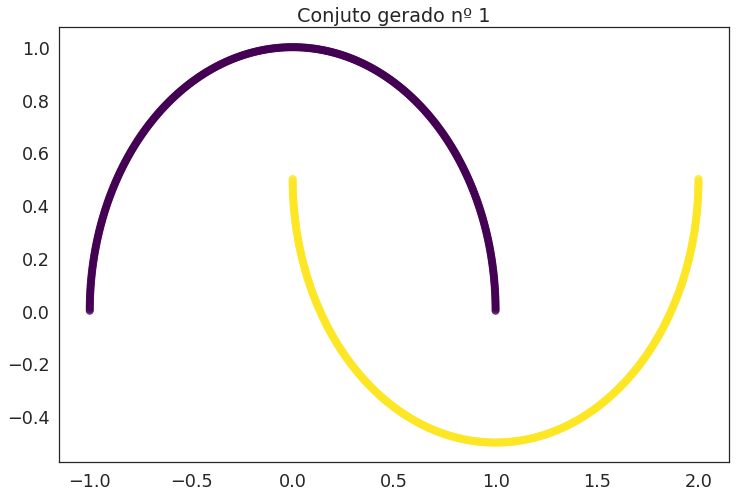

In [ ]:
plt.figure(figsize=(12,8))

plt.scatter(x_c1[:,0], x_c1[:,1], c = y_c1, cmap='viridis', s=50, alpha=0.7)

plt.title('Conjuto gerado nº 1')
  
plt.show(True)

Percebe-se que os dados distribuem-se, aparentemente, em forma de parábolas. Pode-se ver, ainda, que eles podem ser perfeitamente separáveis. 

A seguir é feita uma breve análise dos dados gerados.

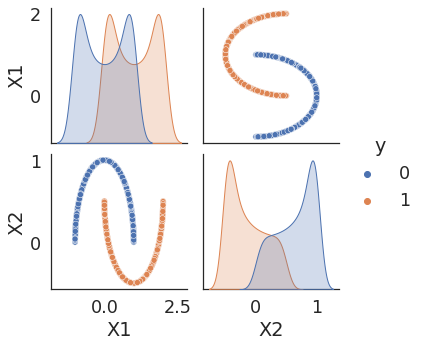

In [ ]:
data_aux = pd.DataFrame({"X1":x_c1[:,0], "X2":x_c1[:,1], "y":y_c1})
sns.pairplot(data_aux, hue = "y")
plt.show()

Assim como anteriormente, percebe-se a perfeita correlação não linear entre os atributos $X_1$ e $X_2$. Mediante a diagonal principal, na qual constam os gráficos com a estimativa não paramétrica para as densidades dos atributos, pode-se notar que os atributos possuem diferentes distribuições quando estratificados pela variável resposta.

Obtendo estatísticas descritivas do conjunto:

In [ ]:
round(data_aux.describe(), 4)

X1         X2          y
count  1000.0000  1000.0000  1000.0000
mean      0.5000     0.2500     0.5000
std       0.8670     0.4940     0.5003
min      -1.0000    -0.5000     0.0000
25%      -0.0008    -0.2049     0.0000
50%       0.5000     0.2500     0.5000
75%       1.0008     0.7049     1.0000
max       2.0000     1.0000     1.0000

Mediante as estatísticas descritivas acima e os gráficos de dispersão e histograma, opta-se pela realização de transformações nas variáveis. Escolheu-se a normalização no intervalo $[0, 1]$ uma vez que, dentre outros classificadores será usado o modelo KNN, que envolve cálculos de distâncias e, por isso, não deve receber valores muito discrepantes.

Classificando os dados através dos classificadores Naive Bayes, K-vizinhos (KNN) e Regressão Logística:

In [ ]:
print("Acurácia Naive Bayes:         ", class_naive_bayes(x_c1, y_c1))
print()

print("Acurácia k-vizinhos:          ", class_knn(x_c1, y_c1))
print()

print("Acurácia regressão logística: ", class_reg_log(x_c1, y_c1))

Acurácia Naive Bayes:          0.885

Melhores parâmetros: {'metric': 'minkowski', 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
Acurácia k-vizinhos:           1.0

Acurácia regressão logística:  0.89


Assim como o esperado o classficador Naive Bayes e a Regressão Logística apresentaram acurácias menores do que a do $k$-vizinhos. Isso se deve a dois motivos diferentes: primeiro que, para o Naive Bayes, a suposição de inpendência entre os atributos não se sustenta tendo em vista que, como visto nos gráficos de dispersão, os atributos aparentam ter perfeita correlação não liner; segundo que, no que se refere à Regressão Logística, tem-se que a mesma apresenta uma região de decisão linear, que não é a mais adequada para esse conjunto de dados em específico. 

Ademais, o $k$-vizinhos apresenta um acerto total quanto a classificação (acurácia igual a $1$), isso porque a região de decisão do KNN é bem adaptativa à estrutura parabólica presente nos dados. 

#### Segundo conjunto: $ruído = 0.5$

Gerando valores:

In [ ]:
x_c2o, y_c2o = sampleValues(noise = 0.5)

# Criando uma copia para ser utilizada
x_c2 = x_c2o.copy()
y_c2 = y_c2o.copy()

Visualizando graficamente o conjunto gerado: 

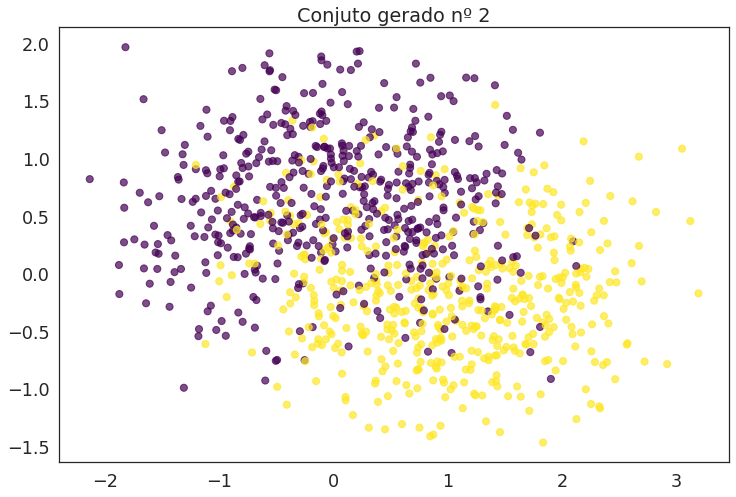

In [ ]:
plt.figure(figsize=(12,8))

plt.scatter(x_c2[:,0], x_c2[:,1], c = y_c2, cmap='viridis', s=50, alpha=0.7)

plt.title('Conjuto gerado nº 2')
  
plt.show(True)

No gráfico acima nota-se uma maior intersecção entre as regiãoes ocupadas pelas duas classes do conjuntos de dados. Isso, certamente, fará com que haja uma dimunuição da performance dos classificadores.

A seguir é feita uma breve análise dos dados gerados.

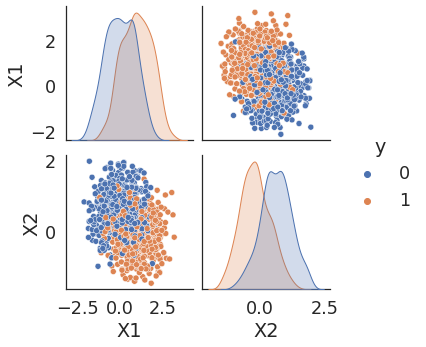

In [ ]:
data_aux = pd.DataFrame({"X1":x_c2[:,0], "X2":x_c2[:,1], "y":y_c2})
sns.pairplot(data_aux, hue = "y")
plt.show()

Com os gráficos das densidades estimadas acima percebe-se que as distribuições dos atributos são diferentes quando analisadas pelas classes da variável resposta. Ainda, nos gráficos de dispersão é possível notar que as observações relacionadas à classe $0$ tendem a ficar próximas, ocorrendo o mesmo para os dados da classe $1$.

Obtendo estatísticas descritivas do conjunto:

In [ ]:
round(data_aux.describe(), 4)

X1         X2          y
count  1000.0000  1000.0000  1000.0000
mean      0.4919     0.2311     0.5000
std       0.9979     0.6939     0.5003
min      -2.1320    -1.4684     0.0000
25%      -0.2208    -0.2869     0.0000
50%       0.5294     0.2375     0.5000
75%       1.2258     0.7477     1.0000
max       3.1956     1.9631     1.0000

Por intermédio das estatísticas descritivas e dos gráficos apresentados, opta-se pela normalização no intervalo $[0, 1]$ pelos mesmos motivos já menciondados (apresentados no $ruido = 0$).

Classificando os dados:

In [ ]:
print("Acurácia Naive Bayes:         ", class_naive_bayes(x_c2, y_c2))
print()

print("Acurácia k-vizinhos:          ", class_knn(x_c2, y_c2))
print()

print("Acurácia regressão logística: ", class_reg_log(x_c2, y_c2))

Acurácia Naive Bayes:          0.855

Melhores parâmetros: {'metric': 'minkowski', 'n_neighbors': 19, 'p': 3, 'weights': 'uniform'}
Acurácia k-vizinhos:           0.865

Acurácia regressão logística:  0.855


Nesse caso o melhor modelo, com base na acurácia, continua sendo o $k$-vizinhos. Todavia, tem-se uma maior similaridade entre as acurácias dos três métodos. Destaca-se, ainda, que o aumento do ruído influenciou fortemente o resultado da acurácia do $k$-vizinhos (que caiu de $1.0$ para $0.865$).

#### Terceiro conjunto: $ruido = 1.0$

Gerando valores:

In [ ]:
x_c3o, y_c3o = sampleValues(noise = 1)

# Criando uma copia para ser utilizada
x_c3 = x_c3o.copy()
y_c3 = y_c3o.copy()

Visualizando graficamente o conjunto gerado: 

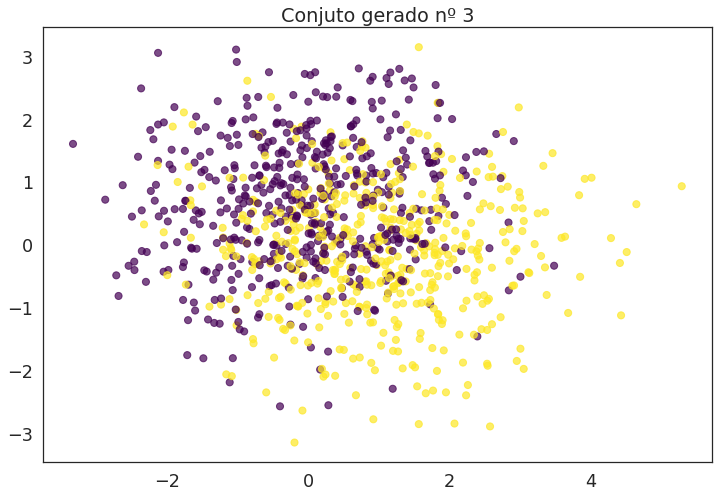

In [ ]:
plt.figure(figsize=(12,8))

plt.scatter(x_c3[:,0], x_c3[:,1], c = y_c3, cmap='viridis', s=50, alpha=0.7)

plt.title('Conjuto gerado nº 3')
  
plt.show(True)

No gráfico de dispersão acima tem-se que os dados estão ainda mais "confundidos", ou seja, as observações relacionadas às classes $0$ e $1$ estão ocupando as mesmas regiões.

A seguir é feita uma breve análise dos dados gerados.

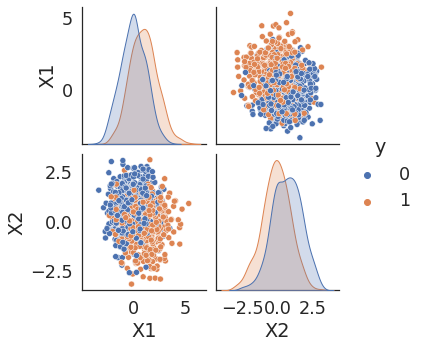

In [ ]:
data_aux = pd.DataFrame({"X1":x_c3[:,0], "X2":x_c3[:,1], "y":y_c3})
sns.pairplot(data_aux, hue = "y")
plt.show()

Acima é possível observar uma maior "confusão" nos gráficos de dispersão. Nas estimativas das densidades, as estimativas das densidades dos atributos relacionados à classe $0$ (representadas em azul) estão mais próximas das estimativas das densidades relacionadas à classe $1$ (representadas em laranja), mostrando que, eventualmente, a performance dos classificadores irá diminuir. 

Acrescenta-se, ainda, que tais estimativas apresentam uma mesma estrutura de variância.

Obtendo estatísticas descritivas do conjunto:

In [ ]:
round(data.describe(), 4)

X1         X2
count  1000.0000  1000.0000
mean      0.5000     0.2500
std       0.8670     0.4940
min      -1.0000    -0.5000
25%      -0.0008    -0.2049
50%       0.5000     0.2500
75%       1.0008     0.7049
max       2.0000     1.0000

Mediante as estatísticas descritivas acima e os gráficos de dispersão e histograma, opta-se pela realização de transformações nas variáveis.  Escolheu-se a normalização no intervalo $[0, 1]$ uma vez que, dentre outros classificadores será usado o modelo KNN, que envolve cálculos de distâncias e, por isso, não deve receber valores muito discrepantes.

Classificando os dados:

In [ ]:
print("Acurácia Naive Bayes:         ", class_naive_bayes(x_c3, y_c3))
print()

print("Acurácia k-vizinhos:          ", class_knn(x_c3, y_c3))
print()

print("Acurácia regressão logística: ", class_reg_log(x_c3, y_c3))

Acurácia Naive Bayes:          0.685

Melhores parâmetros: {'metric': 'manhattan', 'n_neighbors': 15, 'p': 2, 'weights': 'uniform'}
Acurácia k-vizinhos:           0.65

Acurácia regressão logística:  0.675


Com base nos valores acima, tem-se que o Naive Bayes é o classificador que apresenta a maior acurácia. Com o aumento do ruído há a dimuição da correlação não linear entre os atributos e, então, a suposição de independência, preconizada pelo Naive Bayes, começa a fazer um pouco mais de sentido. 

Destaca-se ainda que, como o $k$-vizinhos se adapta muito bem aos dados (ou seja, ele constrói regiões de decisão que funcionam muito bem para o conjunto de treinamento), é possível que o mesmo não esteja conseguindo generalizar tão bem o conjunto de teste (ou seja, há possibilidade de estar ocorrendo *overfitting*).

### 7) Considerando os dados do código anterior, compare os algoritmos: árvores de decisão, forestas aleatórias e bagging. Use o método *selection.GridSearchCV* da biblioteca *scikit-learn* para determinar os melhores parâmetros dos modelos.

Como é dito para utilizar os mesmos dados que no exercício anterior, é necessário executá-lo antes deste para que os dados fiquem salvos nas variáveis $x_{c1}o$, $y_{c1}o$, $x_{c2}o$, $y_{c2}o$, $x_{c3}o$ e $y_{c3}o$. 

Uma vez executado e obtidas as variáveis, serão definidos, a seguir, os novos classificadores.

In [ ]:
np.random.seed(12)
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Definindo o classificador arvores de decisão
def class_decision_tree(x_, y_):
  # Prepara a função para transformar (normalizar) os dados
  scaler = MinMaxScaler(feature_range = (0, 1))
  # Realizando a normalização e colocando em um array
  X = scaler.fit_transform(x_)

  x_train, x_test, y_train, y_test = train_test_split(X, y_, train_size = .8, random_state = 42)
  
  # Optamos por otimizar apenas os parâmetros principais. Sabemos que existem N outros parâmetros.
  grid_params = {
      'criterion': ['gini', 'entropy'], 
      'max_depth': [int(x) for x in np.linspace(2, 100, num = 11)],  # quanto mais profundo a árvore, mais complexo o modelo
                                                  # e maior a tendencia à overfitting. 
      'splitter': ['best', 'random']
  }

  gs = GridSearchCV(
      DecisionTreeClassifier(),
      grid_params,
      verbose = 0, #don't print progress
      cv = 3, #cross validation
      n_jobs = -1 #to use all processors
  )

  gs_results = gs.fit(x_train, y_train)

  # Usando os melhores parâmetros encontrados:
  model = DecisionTreeClassifier(criterion = gs_results.best_params_['criterion'], max_depth = gs_results.best_params_['max_depth'], 
                                 splitter = gs_results.best_params_['splitter'])
  model.fit(x_train, y_train)

  print('Árvore de Decisão:\n')
  print('       Melhores parâmetros:', gs_results.best_params_)

  score = accuracy_score(y_test, model.predict(x_test))

  return score



from sklearn.ensemble import RandomForestClassifier

# Definindo o classificador florestas aleatórias
def class_random_forest(x_, y_):
  # Prepara a função para transformar (normalizar) os dados
  scaler = MinMaxScaler(feature_range = (0, 1))
  # Realizando a normalização e colocando em um array
  X = scaler.fit_transform(x_)

  x_train, x_test, y_train, y_test = train_test_split(X, y_, train_size = .8, random_state = 42)

  # Optamos por otimizar apenas os parâmetros principais. Sabemos que existem outros parâmetros.
  grid_params = {
      'n_estimators': [int(x) for x in np.linspace(100, 1000, num = 5)], # número de árvores na floresta
      'max_features': ['auto', 'sqrt'],  # número máximo de features consideradas para fazer split em um nó
      'max_depth': [int(x) for x in np.linspace(10, 110, num = 5)] # quanto mais profundo sa árvores, mais complexo o modelo
                                                                    # e maior a tendencia à overfitting. 
  }

  gs = GridSearchCV(
      RandomForestClassifier(),
      grid_params,
      verbose = 0, #don't print progress
      cv = 3, #cross validation
      n_jobs = -1 #to use all processors
  )

  gs_results = gs.fit(x_train, y_train)

  # Usando os melhores parâmetros encontrados:
  model = RandomForestClassifier(n_estimators = gs_results.best_params_['n_estimators'], max_features = gs_results.best_params_['max_features'], 
                                 max_depth = gs_results.best_params_['max_depth'])
  model.fit(x_train, y_train)


  print('Florestas aleatórias:\n')
  print('       Melhores parâmetros:', gs_results.best_params_)

  score = accuracy_score(y_test, model.predict(x_test))

  return score



from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import Perceptron
def class_bagging(x_, y_):
  # Prepara a função para transformar (normalizar) os dados
  scaler = MinMaxScaler(feature_range = (0, 1))
  # Realizando a normalização e colocando em um array
  X = scaler.fit_transform(x_)

  x_train, x_test, y_train, y_test = train_test_split(X, y_, train_size = .8, random_state = 42)

  from sklearn.model_selection import GridSearchCV

  # Optamos por otimizar apenas os parâmetros principais. Sabemos que existem outros parâmetros.
  grid_params = {
      'n_estimators': [10, 100, 1000],  # the number of base estimators in the ensemble
      'max_samples': [float(x) for x in np.linspace(0.05, 1.0, num = 5)] # the number of samples to draw from X to train each base estimator
  }

  # Justificar depois que escolhemos o com maior acuracia
  base_estimator = KNeighborsClassifier() # the base estimator to fit on random subsets of the dataset

  gs = GridSearchCV(
      BaggingClassifier(),
      grid_params,
      verbose = 0, #don't print progress
      cv = 3, #cross validation
      n_jobs = -1 #to use all processors
  )

  gs_results = gs.fit(x_train, y_train)

  # Usando os melhores parâmetros encontrados:
  model = BaggingClassifier(base_estimator = base_estimator, n_estimators = gs_results.best_params_['n_estimators'], 
                                 max_samples = gs_results.best_params_['max_samples'])
  model.fit(x_train, y_train)


  print('Bagging:\n')
  print('       Melhores parâmetros:', gs_results.best_params_)

  score = accuracy_score(y_test, model.predict(x_test))

  return score

A análise irá proceder de mesmo modo: 

1. Normalização no intervalo $[0, 1]$; 
2. Separação em conjunto de treino e teste; 
3. Busca dos melhores hiperparâmetros; 
4. Ajuste do modelo;
5. Predição dos resultados com o conjunto de teste. 

Para o primeiro conjunto, com $ruído = 0$, temos:

In [ ]:
print("       Acurácia: ", class_decision_tree(x_c1, y_c1))
print()
print()

print("       Acurácia: ", class_random_forest(x_c1, y_c1)) 
print()
print() 

print("       Acurácia: ", class_bagging(x_c1, y_c1)) 

Árvore de Decisão:

       Melhores parâmetros: {'criterion': 'gini', 'max_depth': 31, 'splitter': 'random'}
       Acurácia:  1.0


Florestas aleatórias:

       Melhores parâmetros: {'max_depth': 10, 'max_features': 'auto', 'n_estimators': 100}
       Acurácia:  1.0


Bagging:

       Melhores parâmetros: {'max_samples': 0.7625, 'n_estimators': 10}
       Acurácia:  1.0


Como é possível notar com a saída acima, todos os métodos de classificação apresentam uma altíssima acurácia; na verdade, a acurácia obtida pelos $3$ classificadores é a máxima possível ($1$). Isso é explicado pelo baixíssimo nível de ruído nos dados ($ruído = 0$).

Para o segundo conjunto, com $ruído = 0.5$, temos:

In [ ]:
print("       Acurácia: ", class_decision_tree(x_c2, y_c2))
print()
print()

print("       Acurácia: ", class_random_forest(x_c2, y_c2)) 
print()
print() 

print("       Acurácia: ", class_bagging(x_c2, y_c2)) 

Árvore de Decisão:

       Melhores parâmetros: {'criterion': 'gini', 'max_depth': 2, 'splitter': 'best'}
       Acurácia:  0.885


Florestas aleatórias:

       Melhores parâmetros: {'max_depth': 10, 'max_features': 'auto', 'n_estimators': 1000}
       Acurácia:  0.855


Bagging:

       Melhores parâmetros: {'max_samples': 0.2875, 'n_estimators': 1000}
       Acurácia:  0.86


Como o esperado, ao aumentar o ruído dos dados tem-se uma diminuição na acurácia dos três modelos. Salienta-se que, nesse caso, os três métodos foram bastante similares com uma pequena vantagem para a Árvore de Decisão.

Para o terceiro conjunto, com $ruído = 1.0$, temos:

In [ ]:
print("       Acurácia: ", class_decision_tree(x_c3, y_c3))
print()
print()

print("       Acurácia: ", class_random_forest(x_c3, y_c3)) 
print()
print() 

print("       Acurácia: ", class_bagging(x_c3, y_c3)) 

Árvore de Decisão:

       Melhores parâmetros: {'criterion': 'gini', 'max_depth': 2, 'splitter': 'best'}
       Acurácia:  0.62


Florestas aleatórias:

       Melhores parâmetros: {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 775}
       Acurácia:  0.64


Bagging:

       Melhores parâmetros: {'max_samples': 0.05, 'n_estimators': 100}
       Acurácia:  0.665


Inserindo ainda mais ruído nos dados tem-se que a acurácia diminui ainda mais para os três métodos de classificação apresentados acima.
Destaca-se que, como o espererado, a Floresta Aleatória resultou em uma acurácia maior do que a da Árvores de Decisão, uma vez que o *Random Forest* é a construção de múltiplas árvores de decisão. Ainda, *Bagging* mostrou ser o modelo com maior acurácia dentre os três.

### 8) Considere as bases: Vehicle, winequality-red e vertebralcolumn-3C. Compare os classificadores: (a) Naive Bayes, (b) Florestas aleatórias, (c) k-vizinhos, (d) regressão logística. Considere as medidas: (i) AUC (área sob a curva ROC), (ii) precisão, (iii) medida F1 e (iv) acurácia. Ou seja, faça uma tabela para cada base, onde as linhas representam os classificadores e as colunas, as medidas de avaliação.

Antes de tudo, tem-se uma função que retorna um DataFrame com as métricas pedidas no enunciado do exercício:

In [1]:
def metrics_matrix(real_values,pred_values):
   CM = confusion_matrix(real_values,pred_values)
   TN = CM[0][0]
   FN = CM[1][0] 
   TP = CM[1][1]
   FP = CM[0][1]
   Population = TN+FN+TP+FP
   auc = round(roc_auc_score(real_values, pred_values), 4)
   Precision  = round( TP / (TP+FP),4 )
   Recall     = round( TP / (TP+FN),4 )
   F1 = round ( 2 * ((Precision*Recall)/(Precision+Recall)),4)
   Accuracy   = round( (TP+TN) / Population,4)

   mat_met = pd.DataFrame({"AUC":[auc], "Precisão":[Precision], "F1":[F1], "Acurácia":[Accuracy]})

   return (mat_met)

No enunciado pede-se para analisar os classificadores *Naive Bayes*, Floresta aleatória, $k$-vizinhos e Regressão Logística considerando as métricas AUC, precisão, medida F1 e acurácia para os seguintes *datasets*: *Vehicle*, *winequality-red* e *vertebralcolumn-3C*.

Para obter a medida AUC é necessário um problema de classificação binária, uma vez que AUC significa área abaixo da curva ROC e a curva ROC só existe para classificações dicotômicas.

Em face do exposto acima, como nem todos os *datasets* envolvem classificação dicotômica, vamos analisar os seguintes dados: *winequality-red* (com binarização da variável resposta), *Dataset Advertising* e dados sintéticos gerados pelos autores deste *notebook*.

#### Dataset winequality-red

Primeiramente, tem-se a análise para o conjunto de dados *winequality-red*.

Abaixo tem-se a leitura dos dados.

In [5]:
dados = pd.read_csv("/content/drive/Shareddrives/Introdução à Ciência de Dados/Projeto 3/Dados/winequality-red.csv")

# Caso tenha linhas duplicadas elas são removidas
dados = dados.drop_duplicates()

dados.head()

fixed acidity  volatile acidity  citric acid  ...  sulphates  alcohol  quality
0            7.4              0.70         0.00  ...       0.56      9.4        5
1            7.8              0.88         0.00  ...       0.68      9.8        5
2            7.8              0.76         0.04  ...       0.65      9.8        5
3           11.2              0.28         0.56  ...       0.58      9.8        6
5            7.4              0.66         0.00  ...       0.56      9.4        5

[5 rows x 12 columns]

Nota-se que a leitura dos dados ocorreu de forma correta. Abaxo segue conformações sobre o dataset.

In [6]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1359 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1359 non-null   float64
 1   volatile acidity      1359 non-null   float64
 2   citric acid           1359 non-null   float64
 3   residual sugar        1359 non-null   float64
 4   chlorides             1359 non-null   float64
 5   free sulfur dioxide   1359 non-null   float64
 6   total sulfur dioxide  1359 non-null   float64
 7   density               1359 non-null   float64
 8   pH                    1359 non-null   float64
 9   sulphates             1359 non-null   float64
 10  alcohol               1359 non-null   float64
 11  quality               1359 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 138.0 KB


De forma geral a base de dados está "bem construída", isso é, não existe limpeza nos dados para se fazer.

Para que seja possível usar a medida AUC (área sob a curva roc) é necessário dicotomizar a variável resposta. Para isso, considera-se uma nota acima de $5$ como $1$ e abaixo de $5$ como $0$.

In [7]:
for i in range(0, dados.shape[0]):
  if dados.iloc[i, 11] > 5:
    dados.iloc[i, 11] = 1
  else:
    dados.iloc[i, 11] = 0
  
dados.quality.value_counts()

1    719
0    640
Name: quality, dtype: int64

Note que desse modo o registro que recebe $1$ pode ser ententido como um bom produto e, caso contrário, recebe $0$ pode ser entendido como não tão bom assim (ou seja, ruim).

Segue um gráfico de setores que possibilita visualizar se o dataset está balanceado ou não.

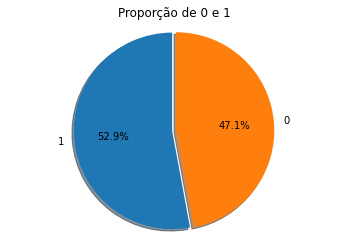

In [8]:
labels = ["1", "0"]
size = dados.quality.value_counts()
explode = [0.02, 0.02]

fig, ax1 = plt.subplots()

ax1.pie(size, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis("equal")
plt.title("Proporção de 0 e 1")
plt.show()

Mediante o gráfico acima é possível notar que as classes da variável resposta estão bem balanceadas. Ou seja, a proporção de $0$s e $1$s estão próximas. Essa análise é importante uma vez que algoritmos de classificação não costumam funcionar muito bem para *datasets* desbalanceados.

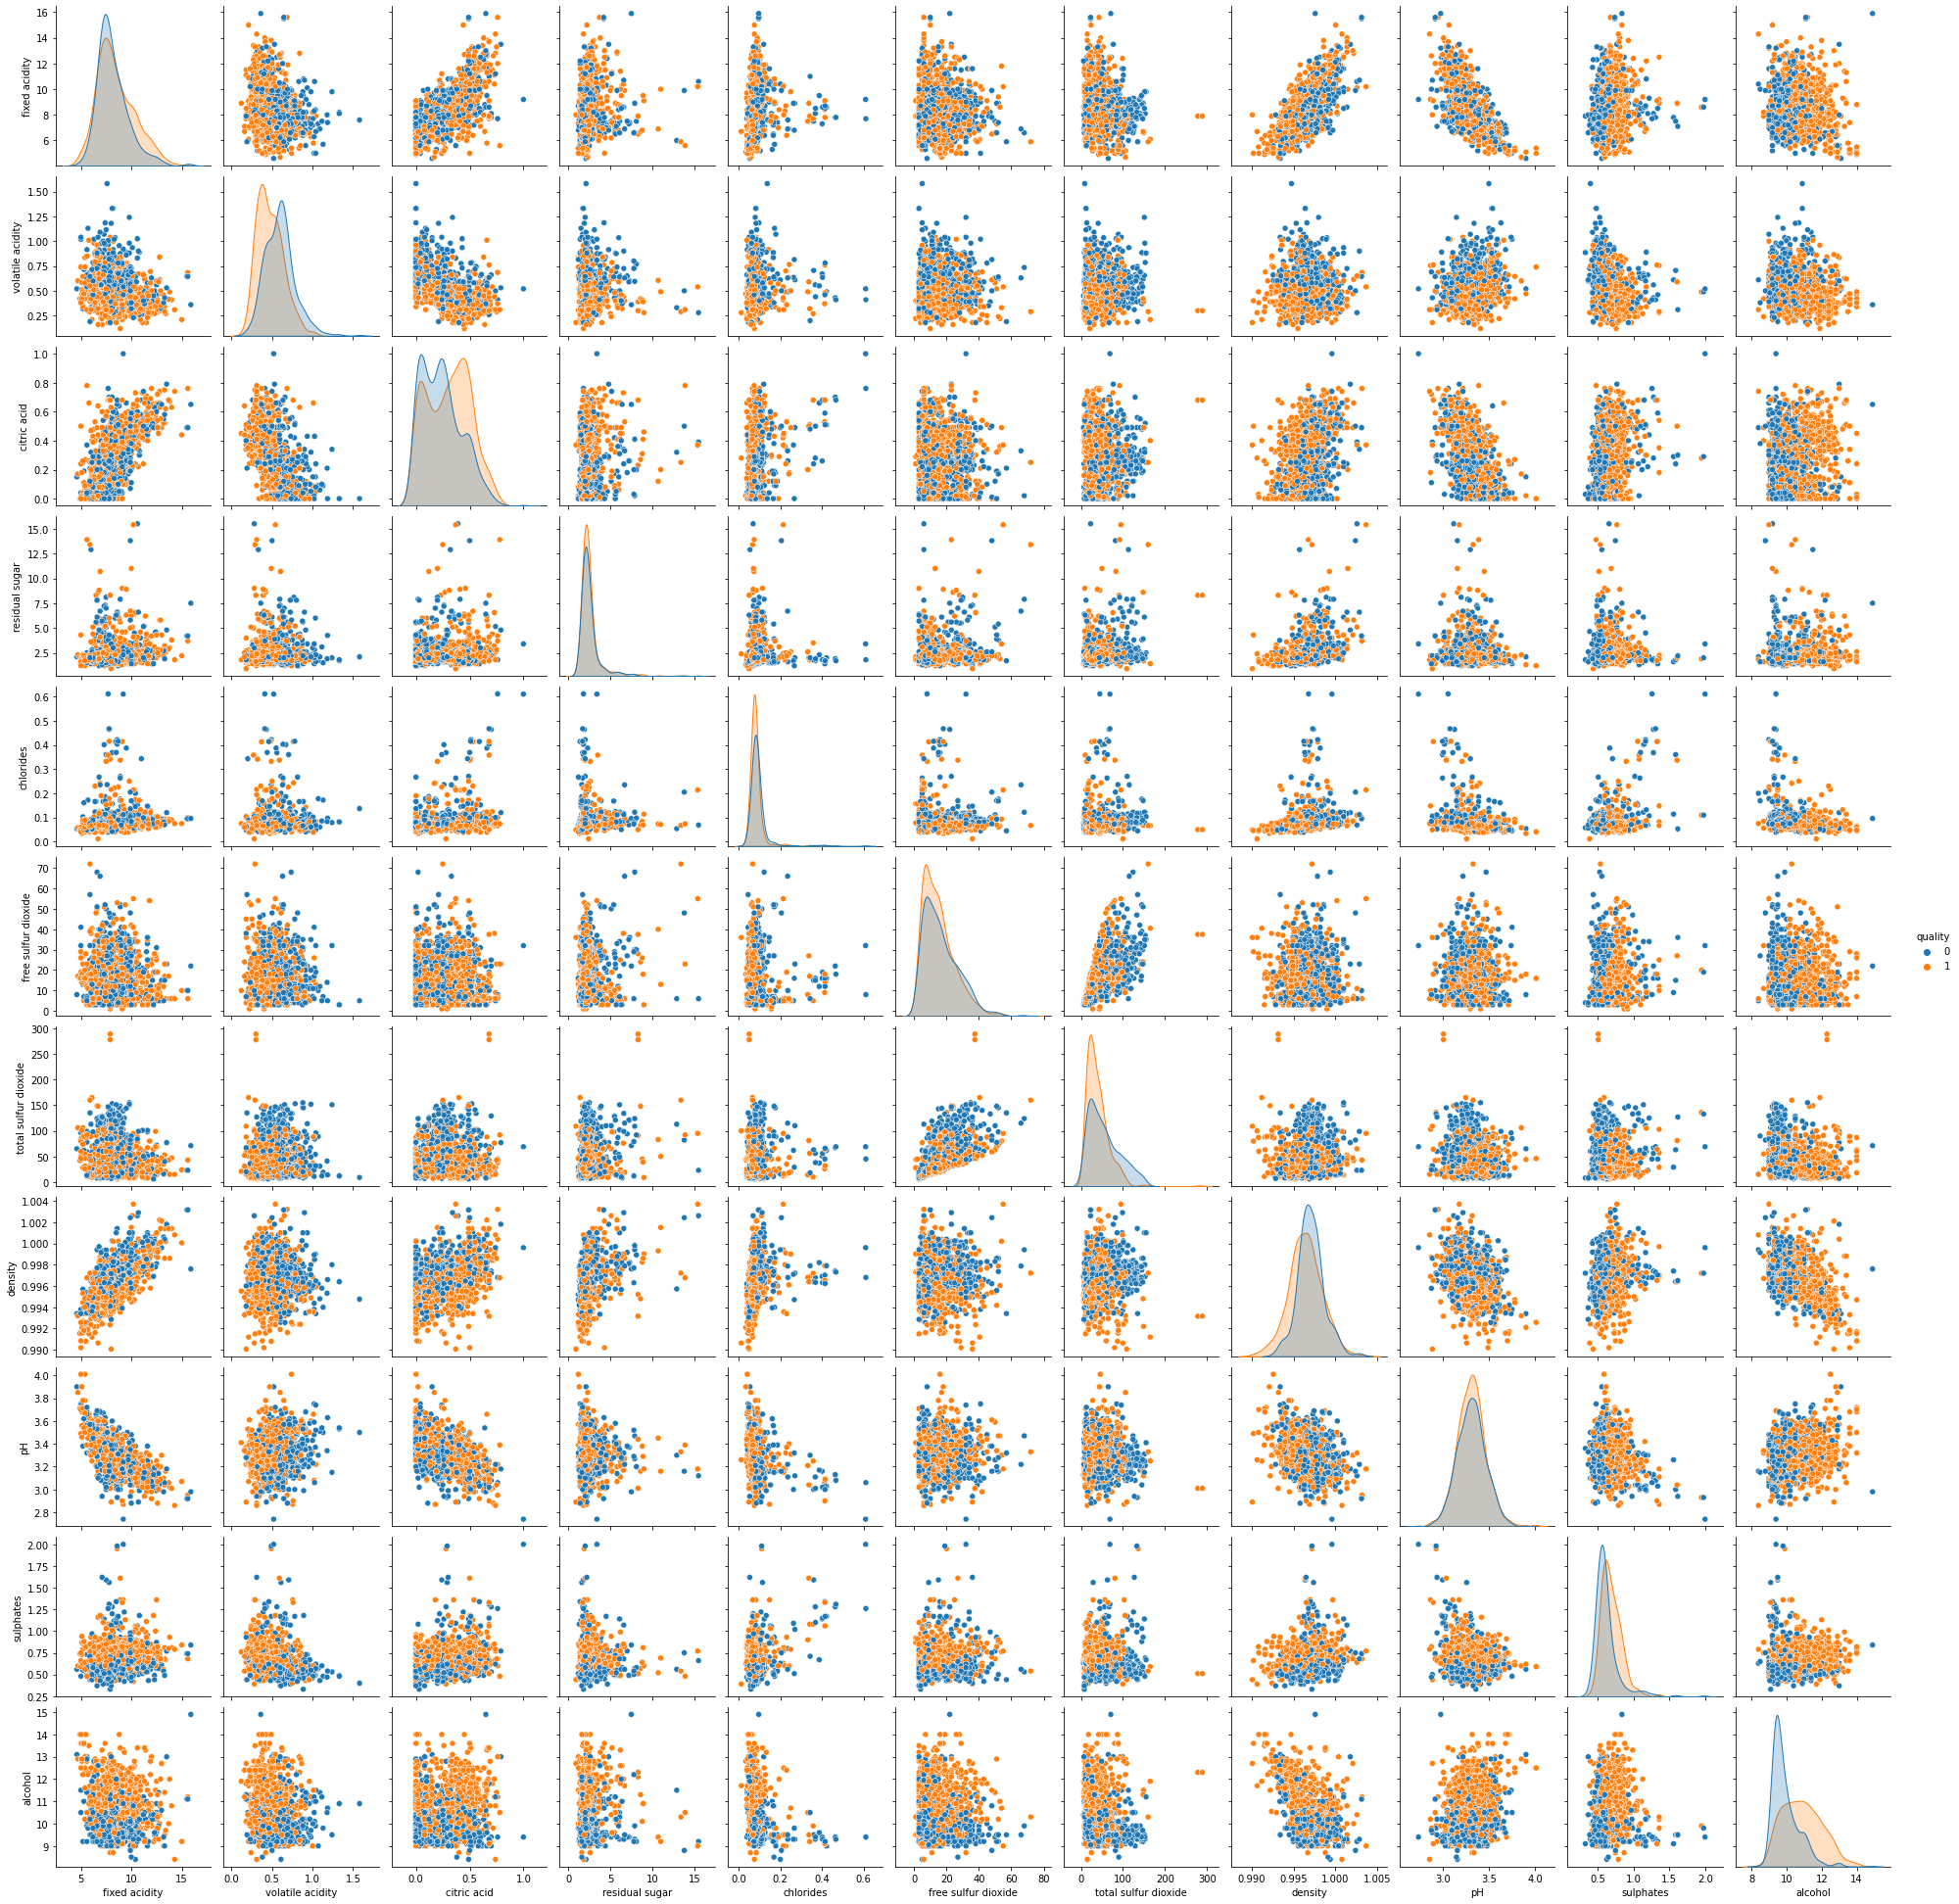

In [9]:
sns.pairplot(dados, hue = "quality")
plt.show()

Mediante os gráficos de dispersão acima, nota-se que alguns pontos destoam dos demais. Possivelmente esses pontos podem ser considerados *outliers*. Como o *dataset* contém esses pontos que podem ser considerados valores extremos, optar-se-á pela padronização dos dados em detrimento da normalização, uma vez que este último é mais sensivel a *outliers*.

Sendo assim, em seguida consta a padronização dos dados. Destaca-se que uma trasformação nos atributos somente é necessaria para alguns métodos de classificação (para o algoritmo KNN, por exemplo, é interessante que haja uma trasformação nos dados, enquanto que na Regressão Logística tal trasformação não é imprescindível). Aqui, aplicar-se-á transformação nos dados para os quatro classificadores.

In [10]:
# passando as variáveis para o formado array do numpy
X = dados.iloc[:, 0:dados.shape[1] - 1].to_numpy()
y = dados.loc[:, "quality"].to_numpy()

# Prepara a função para transformar (padronizar) os dados
scaler = StandardScaler().fit(X)

# Realiza a padronização (média = 0, variância = 1)
X_padrao = scaler.transform(X)

##### NAIVE BAYES

Agora, ajusta-se como modelo de classificação o método Naive Bayes.


In [11]:
from sklearn.naive_bayes import GaussianNB

# dividindo o dataset em trinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_padrao, y, train_size = 0.8)

model = GaussianNB()

# Treinando o modelo
model.fit(X_train, y_train)

# Predizendo X de teste
pred_values = model.predict(X_test)

metrica_NB = metrics_matrix(y_test,pred_values)
metrica_NB.index = ["Naive Bayes"]
metrica_NB

AUC  Precisão      F1  Acurácia
Naive Bayes  0.7279    0.7153  0.7357    0.7279

De modo geral, todas as quatro métricas foram relativamente satisfatórias. Além disso, todas elas estão bem silimares.

##### FLORESTA ALEATÓRIA

Agora utiliza-se a Floresta Aleatória para a classificação. Para escolher os melhores hiperparâmetros do modelo usando validação cruzada, pode-se fazer uso do método *GridSearch* da biblioteca *scikit-learn*.

In [12]:
model = RandomForestClassifier()

# GridSearch para ver quais são os melhores hiperparâmetros 
parameters = {"n_estimators":[x for x in range(5,25)], "criterion":["gini", "entropy"]}

best_model = GridSearchCV(model, param_grid = parameters, cv = 10)

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_train)
print('Best parameters:', best_model.best_params_)
print('Accuracy:', accuracy_score(y_pred, y_train))

# Guardo os melhores hiperparâmetros
criterion, n_estimators = best_model.best_params_.values()

# Contruo o modelo
model=RandomForestClassifier(n_estimators = n_estimators, criterion = criterion)

# Ajusto o modelo
model.fit(X_train, y_train)

# Predizendo
pred_values = model.predict(X_test)

metrica_FA = metrics_matrix(y_test, pred_values)
metrica_FA.index = ["Floresta aleatória"]
metrica_FA

Best parameters: {'criterion': 'entropy', 'n_estimators': 16}
Accuracy: 0.9935602575896965


AUC  Precisão      F1  Acurácia
Floresta aleatória  0.7684    0.7517  0.7758    0.7684

Nota-se que, de modo geral, o modelo de classificação foi satisfatório e todas as métricas resultaram em valores acima de $70\%$.

##### KNN

Agora, ajusta-se o método $k$-vizinhos para a classificação. Assim como anteriormente, usa-se o *GridSearch* para encontrar os melhores hiperparâmetros.

In [14]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier()

# GridSearch para ver quais são os melhores hiperparâmetros 
parameters = {'n_neighbors': np.arange(5, 21), "metric":["euclidean","manhattan","chebyshev","minkowski"]}
best_model = GridSearchCV(model, param_grid = parameters, cv = 10)
best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_train) 
print('Best parameters:', best_model.best_params_)
print('Accuracy:', accuracy_score(y_pred, y_train))

# Guardo os melhores hiperparâmetros
metrica, n_vizinhos = best_model.best_params_.values()

# Modelo com os melhores hiperparâmetros
model = KNeighborsClassifier(n_neighbors = n_vizinhos, metric = metrica)

# Ajuste do modelo
model.fit(X_train, y_train)

# Predizendo X de teste
pred_values = model.predict(X_test)

metrica_KV = metrics_matrix(y_test,pred_values)
metrica_KV.index = ["K-Vizihos"]
metrica_KV

Best parameters: {'metric': 'manhattan', 'n_neighbors': 8}
Accuracy: 0.7801287948482061


AUC  Precisão      F1  Acurácia
K-Vizihos  0.7574      0.75  0.7609    0.7574

Nenhuma das métricas de avaliação do modelo acima resultou em algo não satisfatório. Todas as quatro métricas estão próximas.

##### REGRESSÃO LOGÍSTICA

Por fim avaliaremos o modelo Logístico.

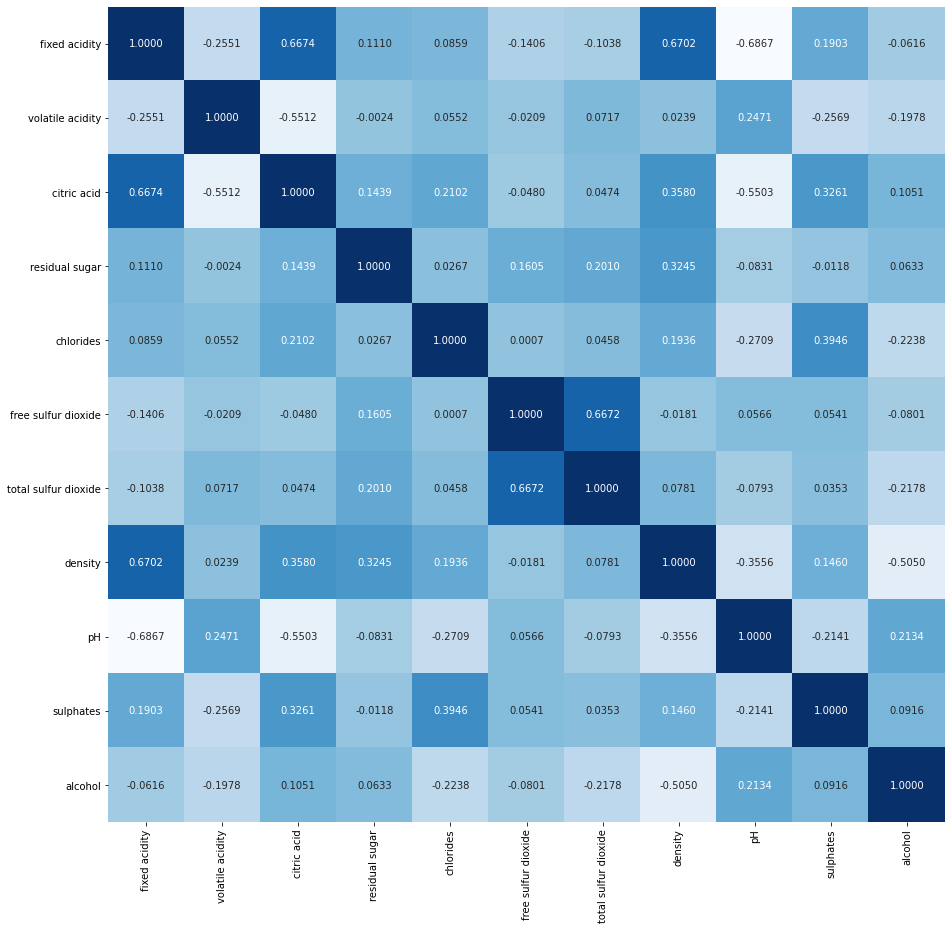

In [15]:
dados1 = dados.drop(columns="quality")

plt.figure(figsize=(15, 15))
corr = np.corrcoef(dados1.values, rowvar=False)
sns.heatmap(corr, annot=True, cmap='Blues', fmt='.4f', cbar=False, xticklabels=dados1.columns, yticklabels=dados1.columns)
plt.show()

Quando tem-se uma alta correlação dos atributos na regressão logística, pode-se ter problemas quanto ao ajuste da mesma. Isso ocorre devido ao fato de que, ao treinar o modelo, uma alta correlação nos atributos pode resultar em inconsistências numéricas (dividir por um numéro muito próximo de zero). É preciso lembrar que, ao ajustar esse método à matriz de planejamento, precisa-se ter posto completo, isto é, as colunas não podem ser linearmente dependentes.

Além disso, a alta correlação entre atributos pode impactar no erro padrão dos estimadores, dificultando a interpretabilidade das estimativas dos parâmetros.

Nesse caso, não se tem interesse em interpretar os parâmetros, interessa-se apenas na predição. Ademais, na figura gráfica acima não há nenhuma correlação muito alta.


In [16]:
# Construo o modelo
model = linear_model.LogisticRegression()

# Treino o modelo
model.fit(X_train, y_train)

# Predição
y_pred = model.predict(X_test)

metrica_RL = metrics_matrix(y_test, y_pred)
metrica_RL.index = ["Regressão Logística"]
metrica_RL

AUC  Precisão      F1  Acurácia
Regressão Logística  0.7316    0.7172  0.7402    0.7316

Para a regressão logística as métricas resultaram em valores similares e acima de $70\%$.

##### COMPARANDO OS 4 CLASSIFICADORES

Colocando os resultados em uma mesma tabela.

In [17]:
results = metrica_NB
results = results.append(metrica_FA.iloc[[0],:])
results = results.append(metrica_KV.iloc[[0],:])
results = results.append(metrica_RL.iloc[[0],:])
results

AUC  Precisão      F1  Acurácia
Naive Bayes          0.7279    0.7153  0.7357    0.7279
Floresta aleatória   0.7684    0.7517  0.7758    0.7684
K-Vizihos            0.7574    0.7500  0.7609    0.7574
Regressão Logística  0.7316    0.7172  0.7402    0.7316

Tendo em vista a tabela acima, fica nítido que os classificadores foram bem similares. Ademais, os melhores classificadores segundo as métricas acima são o $k$-Vizinhos e a Regressão Logística. Naive Bayes e a Floresta aleatória foram relativamente similares, com uma leve vantagem para o primeiro.

O fato da Regressão Logística ter resultado em boas métricas é um indicativo de que a região de decisão é linearmente separável.

Ademais, devido ao alto valor da AUC, tem-se que a sensibilidade e especificidade devem ser altos, o que é um bom indicativo, visto que isso sinaliza que o os métodos estão acertando para as duas classes. 


#### *Dataset* *Advertising*

Agora, será realizada a mesma analise considerando o *dataset Advertising*.

O mesmo pode ser encontrado no [Kaggle](https://www.kaggle.com/fayomi/advertising).

Abaixo tem-se a leitura dos dados.

In [18]:
dados = pd.read_csv("/content/drive/Shareddrives/Introdução à Ciência de Dados/Projeto 3/Dados/advertising.csv")

# Caso tenha linhas duplicadas elas são removidas
dados = dados.drop_duplicates()

dados.head()

Daily Time Spent on Site  Age  ...            Timestamp  Clicked on Ad
0                     68.95   35  ...  2016-03-27 00:53:11              0
1                     80.23   31  ...  2016-04-04 01:39:02              0
2                     69.47   26  ...  2016-03-13 20:35:42              0
3                     74.15   29  ...  2016-01-10 02:31:19              0
4                     68.37   35  ...  2016-06-03 03:36:18              0

[5 rows x 10 columns]

Obtendo informações:

In [19]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1000 non-null   float64
 1   Age                       1000 non-null   int64  
 2   Area Income               1000 non-null   float64
 3   Daily Internet Usage      1000 non-null   float64
 4   Ad Topic Line             1000 non-null   object 
 5   City                      1000 non-null   object 
 6   Male                      1000 non-null   int64  
 7   Country                   1000 non-null   object 
 8   Timestamp                 1000 non-null   object 
 9   Clicked on Ad             1000 non-null   int64  
dtypes: float64(3), int64(3), object(4)
memory usage: 85.9+ KB


A partir das saídas acima podemos perceber que os dados não apresentam nenhum valor ausente nem valores que destoam da realidade (isto é, valores não esperados, como por exemplo uma *string* em um atributo que deveria conter apenas números).

Ainda assim, descremos abaixo o que indica cada variável:

* **Clicked on Ad**: Variável independente, é a respota dicotômica que indica se o usuário clicou ($1$) ou não ($0$) no anúncio;

* **Daily Time Spent on Site**: Variável do tipo numérica (*float*) que indica se o tempo gasto no site;

* **Age**: variável do tipo inteiro que indica a idade do usuário;

* **Area Income**: valor do tipo *float*. Esse atributo indica o tamanho do anúncio na *page*;

* **Daily Internet Usage**: atributo do tipo *float* que indica a quantidade de internet que o usuário utilizou;

* **Ad Topic Line**: variável composta por *strings*;

* **City**: variável composta por *strings*, indica a cidade da qual aquele registro provém;

* **Male**: variável dicotômica que indica se o sexo do usuário é masculino ($1$) ou feminino ($0$);

* **Country**: variável composta por *strings*, indica o país no qual aquele registro provém;

* **Timestamp**: variável que indica o momento no tempo em que a usuário interagiu com o anúncio.

Analisando o balanceamento do conjunto:

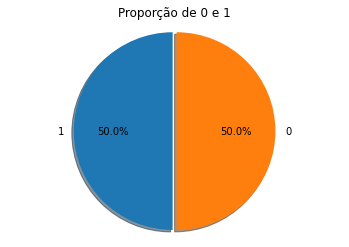

In [20]:
labels = ["1", "0"]
size = dados["Clicked on Ad"].value_counts()
explode = [0.02, 0.02]

fig, ax1 = plt.subplots()

ax1.pie(size, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis("equal")
plt.title("Proporção de 0 e 1")
plt.show()

Pecebe-se, a partir do gráfico de setores acima, que os dados estão perfeitamente balanceados, com $50\%$ de pessoas que clicaram no anúncio e outras $50\%$ que não clicaram. Isso, a principio, é uma excelente constatação, já que métodos de classificação não constumam funcionar bem para datasets desbalanceados.

Para os modelos de classificação explorados nessa questão optar-se-á por trabalhar somente com os atributos contínuos mais o atributo *Male*, que indica se a pessoa é do sexo masculino ou feminino.

In [21]:
dados = dados.loc[:, ["Daily Time Spent on Site",	"Age",	"Area Income",	"Daily Internet Usage", "Male", "Clicked on Ad"]]

Abaixo tem-se gráficos de dispersão juntamente com a estimativa não paramétrica baseada em *kernel* para os atributos.

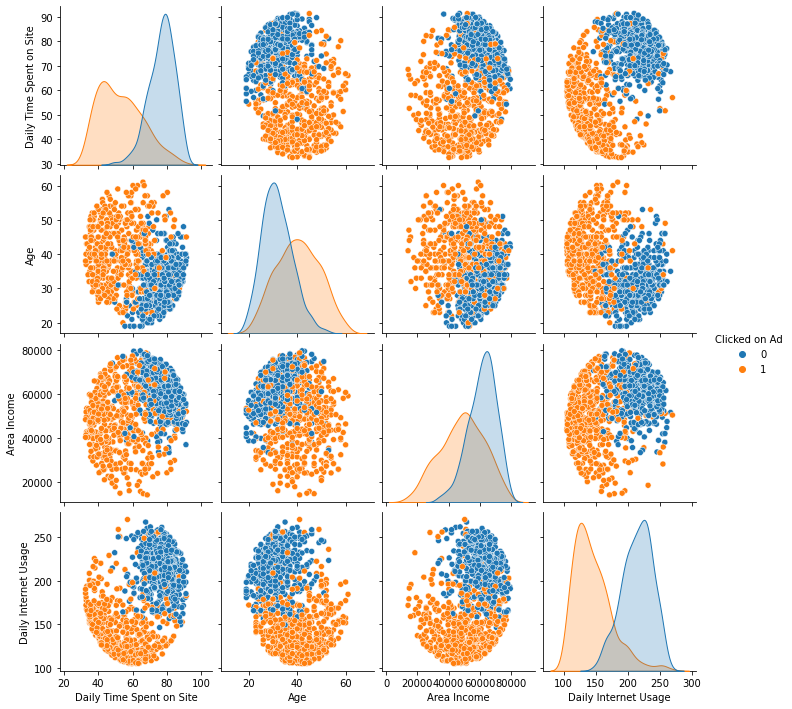

In [22]:
sns.pairplot(dados.drop(columns=["Male"]), hue = "Clicked on Ad")
plt.show()

Os dados apresentam um excelente comportamento. Pode ser visto que os dados possuem boa "separabilidade", ou seja, dentro dos gráficos de dispersão atributo a atributo, tem-se que os valores relacionados a classe $0$ da variável resposta tendem a ficar próximos, ocorrendo o mesmo para a classe $1$. Ademais, mediante os gráficos da estimativa não paramétrica baseada em *kernel*, situados na diagonal principal, tem-se que cada atributo possui distribuição diferente quando estratificado pelas classes da variável dependente.  

Além disso, não se nota nos gráficos de dispersão nenhum valor que possa ser considerado *outlier*. Em consequencia disso será escolhida como transformação nos dados a normalização no intervalo $[0, 1]$.

In [24]:
from sklearn.preprocessing import MinMaxScaler

# passando as variáveis para o formado array do numpy
X = dados.iloc[:, 0:dados.shape[1] - 1].to_numpy()
y = dados.loc[:, "Clicked on Ad"].to_numpy()

# Prepara a função para transformar (normalizar) os dados
scaler = MinMaxScaler(feature_range = (0, 1))

# Realizando a normalização e colocando em um array
X_norm = scaler.fit_transform(X)

# dividindo o dataset em trinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, train_size = 0.8)

X_norm

array([[0.61788203, 0.38095238, 0.73047247, 0.916031  , 0.        ],
       [0.80962094, 0.28571429, 0.83137522, 0.53874561, 1.        ],
       [0.62672106, 0.16666667, 0.69920032, 0.7974331 , 0.        ],
       ...,
       [0.32347442, 0.76190476, 0.43395874, 0.09438189, 1.        ],
       [0.39010709, 0.        , 0.4264012 , 0.50351132, 0.        ],
       [0.2109468 , 0.16666667, 0.24247537, 0.4453929 , 0.        ]])

##### NAIVE BAYES

Agora, será ajustado o modelo Naive Bayes.

In [25]:
model = GaussianNB()

# Treinando o modelo
model.fit(X_train, y_train)

# Predizendo X de teste
pred_values = model.predict(X_test)

metrica_NB = metrics_matrix(y_test, pred_values)
metrica_NB.index = ["Naive Bayes"]
metrica_NB

AUC  Precisão      F1  Acurácia
Naive Bayes  0.98    0.9802  0.9802      0.98

Em decorrencia do "bom comportamento" dos dados, não é nenhuma surpresa os altos valores das métricas mostradas acima. 

##### FLORESTA ALEATÓRIA

Agora, avalia-se o modelo Floresta Aleatória para a classificação. Para encontrar os melhores hiperparâmetros do *Random Forest* faz-se uso do *GridSearch*.

In [26]:
# modelo
model = RandomForestClassifier()

# hiperparametros
parameters = {"n_estimators":[x for x in range(5,20)], "criterion":["gini", "entropy"]}

best_model = GridSearchCV(model, param_grid = parameters, cv = 10)

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_train)
print('Best parameters:', best_model.best_params_)
print('Accuracy:', accuracy_score(y_pred, y_train))

# Guardo os melhores hiperparâmetros
criterion, n_estimators = best_model.best_params_.values()

# Modelo com os melhores hiperparâmetros
model=RandomForestClassifier(n_estimators=n_estimators, criterion=criterion)

# Treinando o modelo
model.fit(X_train, y_train)

# Predizendo com o X_test
pred_values = model.predict(X_test)

metrica_FA = metrics_matrix(y_test, pred_values)
metrica_FA.index = ["Floresta aleatória"]
metrica_FA

Best parameters: {'criterion': 'entropy', 'n_estimators': 17}
Accuracy: 0.99875


AUC  Precisão    F1  Acurácia
Floresta aleatória  0.9501    0.9596  0.95      0.95

Assim como para o Naive Bayes, os resultados considerando a Floresta aleátia foram bons. Todas as métricas se figuram acima dos $90\%$.

##### KNN

Agora, utiliza-se o $k$-Vizinhos para realizar a classificação.

In [29]:
# Parâmetros
parameters = {'n_neighbors': np.arange(5, 21), "metric":["euclidean","manhattan","chebyshev","minkowski"]}

# Modelo
model = KNeighborsClassifier()
# Melhor modelo
best_model = GridSearchCV(model, param_grid = parameters, cv = 10)
best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_train) 
print('Best parameters:', best_model.best_params_)
print('Accuracy:', accuracy_score(y_pred, y_train))

# Guado os melhores hiperparâmetros
metrica, n_vizinhos = best_model.best_params_.values()

# modelo com os melhores hiperparâmetros
model = KNeighborsClassifier(n_neighbors = n_vizinhos, metric = metrica)
model.fit(X_train, y_train)

# Predizendo X de teste
pred_values = model.predict(X_test)

metrica_KV = metrics_matrix(y_test,pred_values)
metrica_KV.index = ["K-Vizinhos"]
metrica_KV

Best parameters: {'metric': 'chebyshev', 'n_neighbors': 19}
Accuracy: 0.96125


AUC  Precisão      F1  Acurácia
K-Vizinhos  0.9553    0.9894  0.9539     0.955

Para esse classificador as métricas também resultaram em valores altos, figurando-se acima dos $90\%$.

##### REGRESSÃO LOGÍSTICA

A seguir será mostrado um gráfico com a correlação dos atributos.

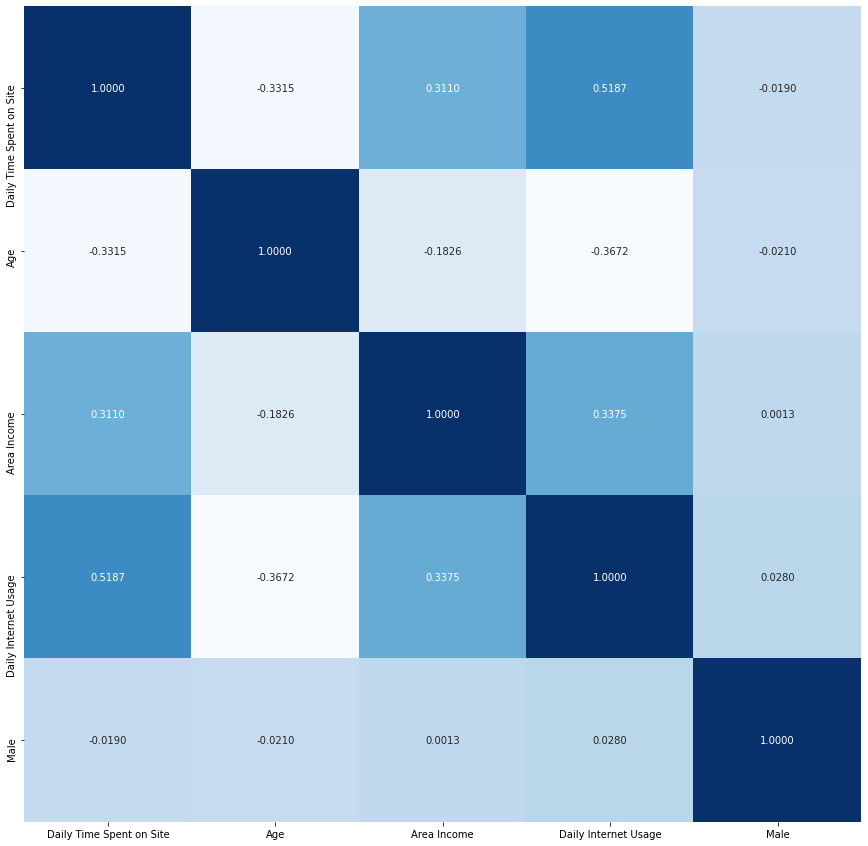

In [30]:
dados1 = dados.drop(columns="Clicked on Ad")

plt.figure(figsize=(15, 15))
corr = np.corrcoef(dados1.values, rowvar=False)
sns.heatmap(corr, annot=True, cmap='Blues', fmt='.4f', cbar=False, xticklabels=dados1.columns, yticklabels=dados1.columns)
plt.show()

Nenhum atributo apresenta forte correlação com outro atributo.

Abaixo, tem-se o uso do classificador Regressão Logística.

In [31]:
# modelo
model = linear_model.LogisticRegression()

# ajuste do modelo
model.fit(X_train, y_train)

# predição do modelo
y_pred = model.predict(X_test)

metrica_RL = metrics_matrix(y_test, y_pred)
metrica_RL.index = ["Regressão Logística"]
metrica_RL

AUC  Precisão      F1  Acurácia
Regressão Logística  0.9652    0.9896  0.9645     0.965

Para a Regressão Logística as quatro métricas também ficaram acima de $90\%$.

##### COMPARANDO OS 4 CLASSIFICADORES

Colocando todos os resultados em uma mesma tabela encontra-se:

In [32]:
results = metrica_NB
results = results.append(metrica_FA.iloc[[0],:])
results = results.append(metrica_KV.iloc[[0],:])
results = results.append(metrica_RL.iloc[[0],:])
results

AUC  Precisão      F1  Acurácia
Naive Bayes          0.9800    0.9802  0.9802     0.980
Floresta aleatória   0.9501    0.9596  0.9500     0.950
K-Vizinhos           0.9553    0.9894  0.9539     0.955
Regressão Logística  0.9652    0.9896  0.9645     0.965

De modo geral, devido à "qualidade" dos dados, tem-se que todas as métricas são altas para os quatro diferentes classificadores. 

Aparentemente o Naive Bayes se mostra levemente melhor do que os demais, o que pode ser um indicativo de que a suposição de que os atributos são independentes é adequada; corroborando essa tese tem-se o fato de que a correlação de Pearson não deu alta (acima de $70\%$) para nenhum par de atributos. Além disso, as altas métricas da Regressão Logística podem indicar que os dados se relacionam de forma linear.

#### Dados Gerados

Por fim, encerra-se essa questão com dados gerados sinteticamente.

Por ser uma classificação binária, a variável resposta $y$ pode assumir valores $0$ ou $1$. A probabilidade com que a variável resposta assuma o valor $1$ será de $0.5$, ou seja, $P(Y = 1) = 0.5$, o que implicará, teoricamente, em um dataset balanceado.

* A primeira variável terá distribuição de *Poisson*, cujo parâmetro λ depende de $y$.

* O segundo atributo terá distribuição *normal* e tanto a média quanto a variância dependerão da variável resposta $y$.

* A terceita covariável tem distribuição *t-Student* com os graus de liberdade dependendo de $y$.

* A quarta e última covariável é *normalmente distribuída*, sendo que a média da mesma é uma função do primeiro atributo e da variável resposta; a dispersão de tal atributo é, ainda, uma função de $y$.


Gerando os dados:

In [33]:
# semente
np.random.seed(40)

y = np.random.binomial(1, 0.5, 1000)
print(y, "\n")

# Covarivel X1
X1 = np.random.poisson(y + 3, 1000)
# Covariável X2
X2 = np.random.normal(y, y + 1, 1000)
# Covariável X3
X3 = np.random.standard_t(np.exp(y+1.5), 1000)
# Covariável X4
X4 = np.random.normal((y + X1 + 0.5) ** 2, np.exp(y) + 0.5, 1000)

X = np.array([X1, X2, X3, X4]).T 
print(X, "\n")

dados = pd.DataFrame()
dados['X1'] = X1
dados["X2"] = X2
dados["X3"] = X3
dados["X4"] = X4
dados["y"] = y

dados.head()

[0 0 1 0 0 0 1 1 1 1 1 1 1 1 0 1 0 0 1 0 0 0 1 1 1 1 1 1 0 1 1 0 0 1 0 0 1
 0 0 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0 1 0 1 1 0 1 0 1
 1 0 0 1 0 1 0 0 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 1 1 0 1 1 0 0 0 1 0 1 1 0 1
 0 1 1 1 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 1 0 1 0 1 1 1 0 1 0 0 1 0
 0 0 0 1 0 0 0 0 0 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 1 1 1 0 0 1 1 1 1 0 1 1
 0 1 1 1 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 1 1 1 0 0 1 1 1 0
 0 0 1 0 0 1 1 1 0 0 0 0 1 1 1 0 1 1 0 0 1 1 1 0 1 0 0 1 0 1 0 1 0 0 1 1 1
 1 1 1 0 0 0 1 1 1 0 1 1 1 1 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1
 1 0 0 0 1 1 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 1 1 0 0 1 1 1 1 0 0 1 0 1 0 1
 0 0 0 0 1 0 1 0 1 0 1 0 1 0 0 1 0 0 0 0 1 0 0 0 1 1 1 0 0 1 0 0 1 0 1 1 1
 0 0 1 1 1 1 0 1 1 1 1 1 0 1 0 0 0 1 0 0 0 1 1 1 1 0 1 0 0 1 0 0 0 1 1 0 1
 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 0 0 1 0 1 1 1 0 0 1 1 1 0 1 0 0 1 1
 1 1 0 1 0 0 0 1 0 0 0 0 1 1 0 1 0 0 1 1 0 0 1 1 0 1 1 0 0 0 0 0 0 1 1 1 1
 1 0 0 1 1 0 1 0 1 1 0 0 

X1        X2        X3         X4  y
0   1  0.141105  0.568248   0.739294  0
1   2 -0.674172 -0.116996   5.795330  0
2   8  1.175440 -0.303534  90.699821  1
3   1  0.472618  0.227094  -1.223125  0
4   1 -0.805755 -0.511874   4.185769  0

Abaixo tem-se um gráfico de setores para a variável resposta.

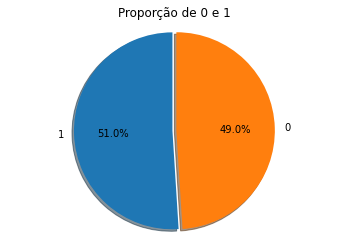

In [34]:
labels = ["1", "0"]
size = dados.y.value_counts()
explode = [0.02, 0.02]

fig, ax1 = plt.subplots()

ax1.pie(size, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis("equal")
plt.title("Proporção de 0 e 1")
plt.show()

Conforme o esperado (haja vista que os valores da variável resposta ($0$ e $1$) foram gerados com probabilidade de $0.5$ cada um), tem-se que o *dataset* está balanceado.

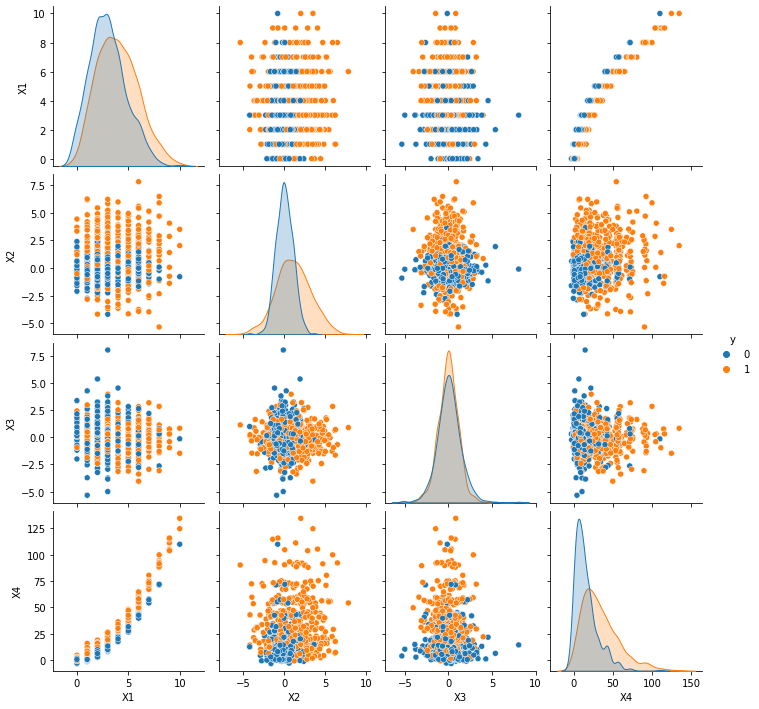

In [35]:
sns.pairplot(dados, hue = "y")
plt.show()

Mediante os gráficos acima percebe-se comportamentos diferentes nos atributos ao estratificar pela variável resposta -- o que não é surpresa, já que as covariáveis foram construídas dessa maneira.

Ainda, com base na análise gráfica, a normalização dos dados no intervalo $[0, 1]$ será efetuada.

In [36]:
# Prepara a função para transformar (normalizar) os dados
scaler = MinMaxScaler(feature_range = (0, 1))

# Realizando a normalização e colocando em um array
X_norm = scaler.fit_transform(X)

# dividindo o dataset em trinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, train_size = 0.8)

X_norm

array([[0.1       , 0.41621733, 0.44107674, 0.02811384],
       [0.2       , 0.35420986, 0.38989613, 0.06486122],
       [0.8       , 0.49488563, 0.37596373, 0.68194891],
       ...,
       [0.4       , 0.55633167, 0.37351764, 0.17002476],
       [0.2       , 0.34625489, 0.43028348, 0.08141815],
       [0.2       , 0.4622925 , 0.54169066, 0.06857496]])

##### NAIVE BAYES

Abaixo tem-se o ajuste do Naive Bayes.

In [37]:
model = GaussianNB()

# Treinando o modelo
model.fit(X_train, y_train)

# Predizendo X de teste
pred_values = model.predict(X_test)

metrica_NB = metrics_matrix(y_test,pred_values)
metrica_NB.index = ["Naive Bayes"]
metrica_NB

AUC  Precisão      F1  Acurácia
Naive Bayes  0.7377    0.7711  0.7111      0.74

O Naive Bayes resultou em métricas relativamente boas -- todas as quatro foram acima de $70\%$.

##### FLORESTA ALEATÓRIA

Agora, avalia-se a classificação com a Floresta Aleatória.

In [38]:
# modelo
model = RandomForestClassifier()

# hiperparametros
parameters = {"n_estimators":[x for x in range(5,20)], "criterion":["gini", "entropy"]}

best_model = GridSearchCV(model, param_grid = parameters, cv = 10)

best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_train)
print('Best parameters:', best_model.best_params_)
print('Accuracy:', accuracy_score(y_pred, y_train))

# Guardo os melhores hiperparâmetros
criterion, n_estimators = best_model.best_params_.values()

# Modelo com os melhores hiperparâmetros
model = RandomForestClassifier(n_estimators = n_estimators, criterion = criterion)

# Ajuste do modelo
model.fit(X_train, y_train)

# Predizendo 
pred_values = model.predict(X_test)

metrica_FA = metrics_matrix(y_test, pred_values)
metrica_FA.index = ["Floresta aleatória"]
metrica_FA

Best parameters: {'criterion': 'entropy', 'n_estimators': 15}
Accuracy: 0.9975


AUC  Precisão      F1  Acurácia
Floresta aleatória  0.919    0.9451  0.9149      0.92

Com a Floresta Aleatória os resultados das quatro métricas foram altos, se figurando acima de $90\%$.

##### KNN

Avalia-se agora o $k$-vizinhos.

In [39]:
# Parâmetros
parameters = {'n_neighbors': np.arange(3, 21), "metric":["euclidean","manhattan","chebyshev","minkowski"]}

# Modelo
model = KNeighborsClassifier()
# Melhor modelo
best_model = GridSearchCV(model, param_grid = parameters, cv = 10)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_train) 
print('Best parameters:', best_model.best_params_)
print('Accuracy:', accuracy_score(y_pred, y_train))

# Guardando os melhores hiperparâmentros
metrica, n_vizinhos = best_model.best_params_.values()

# Modelo com os melhores hiperparâmentros 
model = KNeighborsClassifier(n_neighbors = n_vizinhos, metric = metrica)
model.fit(X_train, y_train)

# Predizendo X de teste
pred_values = model.predict(X_test)

metrica_KV = metrics_matrix(y_test,pred_values)
metrica_KV.index = ["K-Vizihos"]
metrica_KV

Best parameters: {'metric': 'manhattan', 'n_neighbors': 7}
Accuracy: 0.94


AUC  Precisão      F1  Acurácia
K-Vizihos  0.9084     0.954  0.9022      0.91

Os resultados foram bons, sendo todos acima dos $90\%$. Das quatro métricas, a precisão foi a maior, indicando que, daquelas observações que foram consideradas positivas, cerca de $95\%$ foram classificadas corretamente.

##### REGRESSÃO LOGÍSTICA

Por fim, tem-se a Regressão Logística.

Abaixo tem-se o gráfico de correlação entre os atributos.

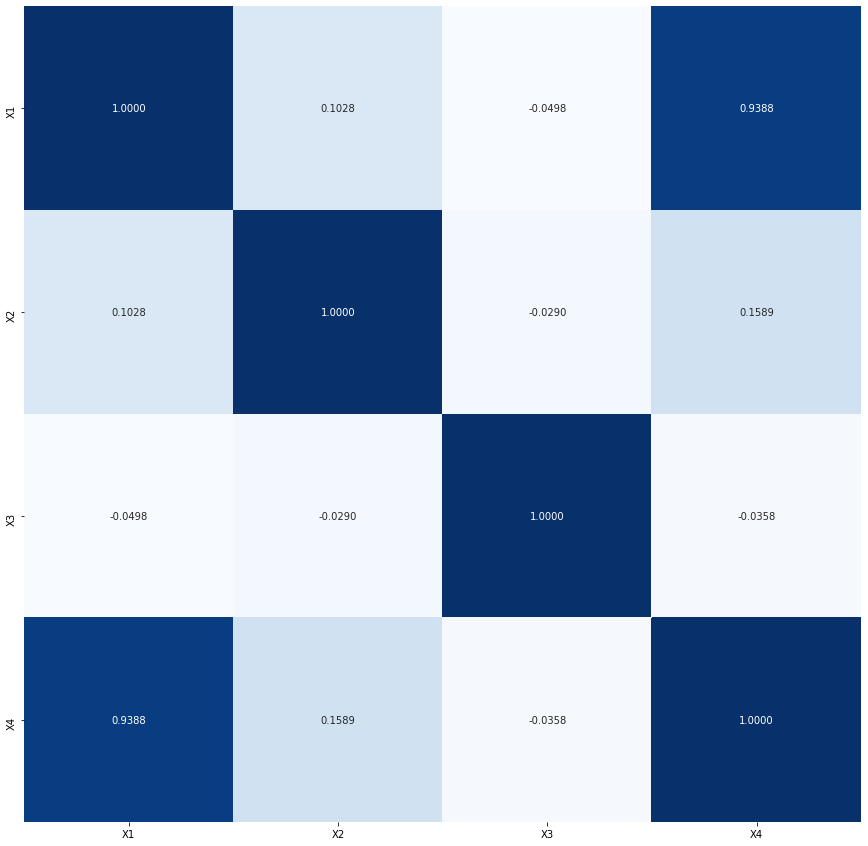

In [40]:
dados1 = dados.drop(columns="y")

plt.figure(figsize=(15, 15))
corr = np.corrcoef(dados1.values, rowvar=False)
sns.heatmap(corr, annot=True, cmap='Blues', fmt='.4f', cbar=False, xticklabels=dados1.columns, yticklabels=dados1.columns)
plt.show()

Na figura acima tem-se os coeficientes de correlação de Pearson para os pares de atributos. Por ele é evidente que os atributos $X_1$ e $X_4$ estão fortemente correlacionados ($0,9388$). Não é por menos: tais atributos foram construídos de forma com que fossem dependentes.

Para avaliar o impacto dessa correlação, ajusta-se duas Regressões Logísticas: uma com as quadro covariáveis e outra somente com as covariáveis $X_1$, $X_2$ e $X_3$.


In [41]:
model = linear_model.LogisticRegression()

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

metrica_RLCT = metrics_matrix(y_test,y_pred)
metrica_RLCT.index = ["Regressão Logística CT"]
metrica_RLCT

AUC  Precisão      F1  Acurácia
Regressão Logística CT  0.7746    0.7708  0.7668     0.775

As métricas para a Regressão Logística, considerando todos os atributos, também resultaram em valores altos, acima de $70\%$.

A seguir realiza-se o mesmo procedimento, com a diferença de que agora não será considerado o atributo $X_4$.

In [42]:
from sklearn import linear_model

model = linear_model.LogisticRegression()

model.fit(X_train[:, 0:3], y_train)

y_pred = model.predict(X_test[:, 0:3])

metrica_RL = metrics_matrix(y_test, y_pred)
metrica_RL.index = ["Regressão Logística S"]
metrica_RL

AUC  Precisão      F1  Acurácia
Regressão Logística S  0.6621    0.6283  0.6762      0.66

Os resultados apresentam uma queda de performance em relação à classificação com a Regressão Logística com todos os atributos.

##### COMPARAÇÃO DOS 4 CLASSIFICADORES

In [43]:
results = metrica_NB
results = results.append(metrica_FA.iloc[[0],:])
results = results.append(metrica_KV.iloc[[0],:])
results = results.append(metrica_RLCT.iloc[[0],:])
results = results.append(metrica_RL.iloc[[0],:])
results

AUC  Precisão      F1  Acurácia
Naive Bayes             0.7377    0.7711  0.7111     0.740
Floresta aleatória      0.9190    0.9451  0.9149     0.920
K-Vizihos               0.9084    0.9540  0.9022     0.910
Regressão Logística CT  0.7746    0.7708  0.7668     0.775
Regressão Logística S   0.6621    0.6283  0.6762     0.660

Nota-se que o Naive Bayes foi o segundo classificador que resultou em *menores* métricas. Isso ocorre porque os atributos $X_1$ e $X_4$ apresentam correlação forte e uma das pressuposições do Naive Bayes é a de que os atributos são não correlacionados. 

Ademais, destaca-se o fato de que, ao retirar o atributo $X_4$ da Regressão Logística, as métricas resultaram em valores menores do que quando se tinha todos os atributos.

### 9) Considere os código abaixo. Avalie como o desbalanceamento influencia nos resultados usando as medidas i) AUC (área sob a curva ROC), (ii) precisão, (iii) medida F1 e (iv) acurácia. Elabore um estudo e proceda com o desenvolvimento dos códigos. Dica: use o método de validação cruzada estratificado na classificação e discuta a comparação com o caso sem o uso de estratificação.

```
# Generate and plot a synthetic imbalanced classification dataset
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where
# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
# summarize class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
  row_ix = where(y == label)[0]
  pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
  pyplot.legend()
pyplot.show()
```

Abaixo tem-se uma função que retorna as métricas preconizadas no enunciado.

In [44]:
def metrics_matrix(real_values,pred_values):
   CM = confusion_matrix(real_values,pred_values)
   TN = CM[0][0]
   FN = CM[1][0] 
   TP = CM[1][1]
   FP = CM[0][1]
   Population = TN+FN+TP+FP
   auc = round(roc_auc_score(real_values, pred_values), 4)
   Precision  = round( TP / (TP+FP),4 )
   Recall     = round( TP / (TP+FN),4 )
   F1 = round ( 2 * ((Precision*Recall)/(Precision+Recall)),4)
   Accuracy   = round( (TP+TN) / Population,4)

   mat_met = pd.DataFrame({"AUC":[auc], "Precisão":[Precision], "F1":[F1], "Acurácia":[Accuracy]})

   return (mat_met)

Função que gera os dados (função que está presente no enunciado).

Counter({0: 9900, 1: 100})


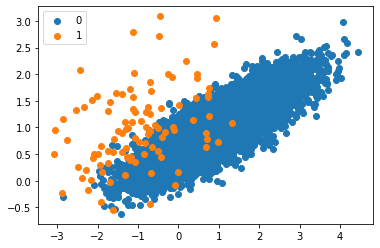

In [ ]:
# Generate and plot a synthetic imbalanced classification dataset
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where
# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
# summarize class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
  row_ix = where(y == label)[0]
  pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
  pyplot.legend()
pyplot.show()

O código abaixo faz as validações estratificadas e não estratificadas.

In [ ]:
for prop in [0.5, 0.75, 0.99]:

  print("Grau de desbalanceamento do dataset:", prop, "\n")
  
  # gero os dados com a desproporção "prop"
  X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
                             n_clusters_per_class=1, weights=[prop], flip_y=0, random_state=10)
  counter = Counter(y)
  print(counter)

  # Para o Random Forest não é necessário realizar transformação

  # Optamos por otimizar apenas os parâmetros principais. Sabemos que existem outros parâmetros.
  grid_params = {
      'n_estimators': [int(x) for x in np.linspace(100, 1000, num = 3)], # número de árvores na floresta
      'max_depth': [int(x) for x in np.linspace(10, 110, num = 3)], # quanto mais profundo sa árvores, mais complexo o modelo e maior a tendencia à overfitting. 
      'criterion' :['gini','entropy']
  }

  # GridSearchCV para os melhores hiper parâmetros
  gs = GridSearchCV(
      RandomForestClassifier(),
      grid_params,
      verbose = 0, #don't print progress
      cv = 5, #cross validation
      n_jobs = -1 #to use all processors
  )

  gs_results = gs.fit(X, y)

  print('Florestas aleatórias:\n')
  print('       Melhores parâmetros:', gs_results.best_params_)

  # Tabela para guardar os resultados
  tab = pd.DataFrame({"Métrica":["AUC", "Precisão", "Acuracia", "F1"],
                      "Estrat - Média":np.zeros(4),
                      "Estrat - DP":np.zeros(4),
                      "Não Estrat - Média":np.zeros(4),
                      "Não Estrat - DP":np.zeros(4)})

  # Vetores para colocar os resultados 
  vauc = []
  vprec = []
  vacc = []
  vf1 = []

  # Validação cruzada estratificada
  cv = StratifiedKFold(n_splits=5, shuffle = True, random_state = 100)

  for train_index, test_index in cv.split(X, y):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Construção do Random Forest
    model = RandomForestClassifier(n_estimators = gs_results.best_params_['n_estimators'],
                                   max_depth = gs_results.best_params_['max_depth'],
                                   criterion = gs_results.best_params_['criterion'])
    # modelo
    model.fit(x_train, y_train)

    # Predição
    y_pred = model.predict(x_test) 

    # Cálculos dos scores
    score_auc = roc_auc_score(y_test, y_pred)
    score_prec = precision_score(y_test, y_pred)
    score = accuracy_score(y_test, y_pred)
    score_f1 = f1_score(y_test, y_pred)

    vauc.append(score_auc)
    vprec.append(score_prec)
    vacc.append(score)
    vf1.append(score_f1)

  # Coloco os resultados em uma tabela
  tab.iloc[0, 1] = np.mean(vauc)
  tab.iloc[1, 1] = np.mean(vprec)
  tab.iloc[2, 1] = np.mean(vacc)
  tab.iloc[3, 1] = np.mean(vf1)
  tab.iloc[0, 2] = np.std(vauc, ddof = 1)
  tab.iloc[1, 2] = np.std(vprec, ddof = 1)
  tab.iloc[2, 2] = np.std(vacc, ddof = 1)
  tab.iloc[3, 2] = np.std(vf1, ddof = 1)

  vauc = []
  vprec = []
  vacc = []
  vf1 = []

  # Validação Cruzada não estratificada
  cv = KFold(n_splits=5, shuffle = True , random_state = 100)

  for train_index, test_index in cv.split(X, y):
    x_train, x_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Construção do modelo
    model = RandomForestClassifier(n_estimators = gs_results.best_params_['n_estimators'],
                                 max_depth = gs_results.best_params_['max_depth'],
                                 criterion = gs_results.best_params_['criterion'])
    
    # Treinamento
    model.fit(x_train,y_train)

    # Predição
    y_pred = model.predict(x_test) 

    # Cálculo das acurácias
    score_auc = roc_auc_score(y_test, y_pred)
    score_prec = precision_score(y_test, y_pred)
    score = accuracy_score(y_test, y_pred)
    score_f1 = f1_score(y_test, y_pred)

    vauc.append(score_auc)
    vprec.append(score_prec)
    vacc.append(score)
    vf1.append(score_f1)

  tab.iloc[0, 3] = np.mean(vauc)
  tab.iloc[1, 3] = np.mean(vprec)
  tab.iloc[2, 3] = np.mean(vacc)
  tab.iloc[3, 3] = np.mean(vf1)
  tab.iloc[0, 4] = np.std(vauc, ddof=1)
  tab.iloc[1, 4] = np.std(vprec, ddof=1)
  tab.iloc[2, 4] = np.std(vacc, ddof=1)
  tab.iloc[3, 4] = np.std(vf1, ddof=1)

  print(tab)

  print('\n')

Grau de desbalanceamento do dataset: 0.5 

Counter({1: 5000, 0: 5000})
Florestas aleatórias:

       Melhores parâmetros: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 1000}
    Métrica  Estrat - Média  Estrat - DP  Não Estrat - Média  Não Estrat - DP
0       AUC        0.924600     0.008835            0.926160         0.005703
1  Precisão        0.925846     0.009462            0.926338         0.007691
2  Acuracia        0.924600     0.008835            0.926000         0.005557
3        F1        0.924474     0.009065            0.926031         0.004093


Grau de desbalanceamento do dataset: 0.75 

Counter({0: 7500, 1: 2500})
Florestas aleatórias:

       Melhores parâmetros: {'criterion': 'entropy', 'max_depth': 10, 'n_estimators': 100}
    Métrica  Estrat - Média  Estrat - DP  Não Estrat - Média  Não Estrat - DP
0       AUC        0.912533     0.011194            0.912598         0.011861
1  Precisão        0.916804     0.010617            0.915136         0.011605
2 

Como é possível observar através dos resultados acima, com o aumento da desproporcionalidade dos dados vê-se que algumas métricas diminuem significativamente.

Na primeira saída, quando a proproção das classes é $50\%$ a $50\%$, tem-se que os resultados são bem similares, uma vez que os métodos (validação estratificada e não estratificada) se comportam de maneira semelhante nesse cenário. Os desvios padrão referentes às métricas apresentadas também são bem similares, sendo os do estratificado levemente maiores.

Na segunda tabela, onde $25\%$ dos dados são referentes à classe $1$, tem-se que a validação estraticada e não estratificada também são similares, com uma leve vantagem para o estratificado. Os desvios padrão dos métodos são similares. Assim como anteriormente, tem-se que os resultados das duas validações são similares e vê-se, como o esperado, uma leve superioridade da validação estratificada. 

Finalmente, destaca-se que a métrica que mais diminuiu foi a medida F1, a qual é dada pela fórmula:

$$F1 = \frac{2 * Precisão * Recall}{Precisão + Recall}$$

Por outro lado:

$$Precisão = \frac{VP}{VP + FP} \text{ e } Recall = \frac{VP}{VP + FN}$$

Sendo assim, percebe-se que essa métrica está muito relacionada com a classe Positiva (a classe positiva corresponde à classe $1$). Como esta classe está em menor proporção, tem-se que o valor da medida F1 é o que mais diminui quando aumenta-se a desproporcionalidade entre as classes (por ser, entre as apresentadas, a métrica mais afetada por essa desproporcionalidade).  

### 10) Realize a classificação da base *Titanic*. Use os métodos de seleção de modelos e determine o melhor modelo e seus hiperparâmetros.

Sumário de passos a serem aqui desenvolvidos, com base no *dataset Titanic*, disponível no [Kaggle](https://www.kaggle.com/c/titanic):

1. Formulação do problema e preparo dos dados;
2. Limpeza e normalização dos dados;
3. Análise exploratória, Estatística Descritiva, PCA;
4. Classificação, Feature Selection e predição dos valores no conjunto de teste.

A seguir será dado início ao processamento.

#### Formulação do problema e preparo dos dados

Considerando a base de dados de passageiros que viajaram no Titanic, tem-se os seguintes atributos:

1. **PassengerId**: Número de identificação do passageiro;
2. **Survived**: Indica se o passageiro sobreviveu ao desastre. É atribuído o valor de 0 para aqueles que não sobreviveram, e 1 para quem sobreviveu;
3. **Pclass**: Classe na qual o passageiro viajou. É informado 1 para primeira classe; 2 para segunda; e 3 para terceira;
4. **Name**: Nome do passageiro;
5. **Sex**: Sexo do passageiro;
6. **Age**: Idade do passageiro em anos;
7. **SibSp**: Quantidade de irmãos e cônjuges a bordo;
8. **Parch**: Quantidade de pais e filhos a bordo;
9. **Ticket**: Número da passagem;
10. **Fare**: Preço da passagem;
11. **Cabin**: Número da cabine do passageiro;
12. **Embarked**: Indica o porto no qual o passageiro embarcou. Há apenas três valores possíveis: Cherbourg, Queenstown e Southampton, indicados pelas letras “C”, “Q” e “S”, respectivamente.

O objetivo do exercício é classificar os passageiros como sobreviventes (ou não) de acordo com o conjunto de atributos.


Carregando os dados e verificando se o carregamento ocorreu da maneira correta:

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

# Carregando os dados em um objeto
train_titanic = pd.read_csv("/content/drive/Shareddrives/Introdução à Ciência de Dados/Projeto 3/Dados/trainTitanic.csv")
test_titanic = pd.read_csv("/content/drive/Shareddrives/Introdução à Ciência de Dados/Projeto 3/Dados/testTitanic.csv")

Mounted at /content/drive/


In [ ]:
train_titanic.head(5)

PassengerId  Survived  Pclass  ...     Fare Cabin  Embarked
0            1         0       3  ...   7.2500   NaN         S
1            2         1       1  ...  71.2833   C85         C
2            3         1       3  ...   7.9250   NaN         S
3            4         1       1  ...  53.1000  C123         S
4            5         0       3  ...   8.0500   NaN         S

[5 rows x 12 columns]

É possível observar que o conjunto de testes, que deve ser classificado, não possui a classe *target* *survived*:

In [ ]:
test_titanic.head(5)

PassengerId  Pclass  ... Cabin Embarked
0          892       3  ...   NaN        Q
1          893       3  ...   NaN        S
2          894       2  ...   NaN        Q
3          895       3  ...   NaN        S
4          896       3  ...   NaN        S

[5 rows x 11 columns]

Verificando o tamanho dos conjuntos:

In [ ]:
print("Número de linhas e colunas no conjunto de treinamento:", train_titanic.shape)
print("Número de linhas e colunas no conjunto de teste:", test_titanic.shape)

Número de linhas e colunas no conjunto de treinamento: (891, 12)
Número de linhas e colunas no conjunto de teste: (418, 11)


#### Limpeza e normalização dos dados

É possível observar que atributos como *PassengerId*, *Name*, *Ticket* e *Cabin* não trazem informações adicionais relevantes à classificação; logo, descartaremos as mesmas dos dois conjuntos (teste e treino).

In [ ]:
train_titanic.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1, inplace = True)
train_titanic.head(5)

Survived  Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0         0       3    male  22.0      1      0   7.2500        S
1         1       1  female  38.0      1      0  71.2833        C
2         1       3  female  26.0      0      0   7.9250        S
3         1       1  female  35.0      1      0  53.1000        S
4         0       3    male  35.0      0      0   8.0500        S

In [ ]:
passengerID_test = test_titanic['PassengerId'] # ficará salvo pois será necessário no momento da submissão ao kaggle

test_titanic.drop(['PassengerId', 'Name', 'Ticket', 'Cabin'], axis = 1, inplace = True)
test_titanic.head(5)

Pclass     Sex   Age  SibSp  Parch     Fare Embarked
0       3    male  34.5      0      0   7.8292        Q
1       3  female  47.0      1      0   7.0000        S
2       2    male  62.0      0      0   9.6875        Q
3       3    male  27.0      0      0   8.6625        S
4       3  female  22.0      1      1  12.2875        S

Verificando a existência de valores nulos:

In [ ]:
NAs = pd.concat([train_titanic.isnull().sum()], axis=1, keys=['# nulos'])
NAs[NAs.sum(axis=1) > 0]

# nulos
Age           177
Embarked        2

In [ ]:
NAs = pd.concat([test_titanic.isnull().sum()], axis=1, keys=['# nulos'])
NAs[NAs.sum(axis=1) > 0]

# nulos
Age        86
Fare        1

Como existem apenas $2$ valores ausentes no atributo *Embarked* no conjunto de treino, os mesmos serão substituídos pela moda.

In [ ]:
train_titanic['Embarked'].fillna(train_titanic['Embarked'].mode()[0], inplace=True)

Como existe apenas $1$ valor ausente no atributo *Fare* no conjunto de teste, será feita uma análise de *outliers* no atributo, de forma a concluir se substituiremos o mesmo pela média ou pela moda.

In [ ]:
q_low = test_titanic["Fare"].quantile(0.01)
q_hi  = test_titanic["Fare"].quantile(0.99)

print(test_titanic[(test_titanic["Fare"] > q_hi) & (test_titanic["Fare"] < q_low)])

Empty DataFrame
Columns: [Pclass, Sex, Age, SibSp, Parch, Fare, Embarked]
Index: []


Como não existem *outliers*, a substituição será feita pela média.


In [ ]:
test_titanic['Fare'].fillna(test_titanic['Fare'].mean(), inplace=True)

No conjunto de treino existem $177$ valores nulos relativos ao atributo *Age*. Será analisada, a seguir, a existência (ou inexistência) de *outliers*, para que se substitua os valores pela média ou pela moda.

In [ ]:
q_low = train_titanic["Age"].quantile(0.01)
q_hi  = train_titanic["Age"].quantile(0.99)

print(train_titanic[(train_titanic["Age"] > q_hi) & (train_titanic["Age"] < q_low)])

Empty DataFrame
Columns: [Survived, Pclass, Sex, Age, SibSp, Parch, Fare, Embarked]
Index: []


Como não existem *outliers*, a substituição será feita com base na média do atributo *Age*.

In [ ]:
# Criando uma cópia sem inclusão de valores faltantes que será postumamente utilizada
train_titanic_miss_age = train_titanic.copy()

train_titanic['Age'].fillna(train_titanic['Age'].mean(), inplace=True)

print('A idade média dos tripulantes é: ', test_titanic['Age'].mean())

A idade média dos tripulantes é:  30.272590361445783


Agora, o mesmo será feito no conjunto de teste, que possui $86$ valores nulos correspondentes ao atributo *Age*.

In [ ]:
q_low = test_titanic["Age"].quantile(0.01)
q_hi  = test_titanic["Age"].quantile(0.99)

print(test_titanic[(test_titanic["Age"] > q_hi) & (test_titanic["Age"] < q_low)])

Empty DataFrame
Columns: [Pclass, Sex, Age, SibSp, Parch, Fare, Embarked]
Index: []


Como não existem *outliers*, a substituição será feita com base na média do atributo *Age*.

In [ ]:
test_titanic['Age'].fillna(test_titanic['Age'].mean(), inplace=True)

Por fim, é interessante verificar se todos os valores nulos foram verdadeiramente eliminados:

In [ ]:
NAs = pd.concat([train_titanic.isnull().sum()], axis=1, keys=['# nulos'])
NAs[NAs.sum(axis=1) > 0]

Empty DataFrame
Columns: [# nulos]
Index: []

In [ ]:
NAs = pd.concat([test_titanic.isnull().sum()], axis=1, keys=['# nulos'])
NAs[NAs.sum(axis=1) > 0]

Empty DataFrame
Columns: [# nulos]
Index: []

Agora, é necessário transformar os atributos nominais em numéricos, para possibilitar a classificação e um melhor manuseio. 

Para esse fim, no que tange à covariável *Embarked*, optou-se pelo uso do "get_dummies" — que constrói colunas para cada classe da variável nominal com valores 1 (caso tenha aquela observação no referido registro) e 0 (caso contrário). Ainda, embora o atributo *Pclass* seja constituído de valores númericos, a sua natureza é nominal; sendo assim, também optou-se por utilizar o "get_dummies" nesse caso. 

In [ ]:
# Substituindo atributo Embarked e Pclass

# Treinamento
train_titanic = pd.get_dummies(train_titanic, columns=["Embarked", "Pclass"])

# Teste
test_titanic = pd.get_dummies(test_titanic, columns=["Embarked", "Pclass"])

print(train_titanic.head(5))
print()
print(test_titanic.head(5))

   Survived     Sex   Age  SibSp  ...  Embarked_S  Pclass_1  Pclass_2  Pclass_3
0         0    male  22.0      1  ...           1         0         0         1
1         1  female  38.0      1  ...           0         1         0         0
2         1  female  26.0      0  ...           1         0         0         1
3         1  female  35.0      1  ...           1         1         0         0
4         0    male  35.0      0  ...           1         0         0         1

[5 rows x 12 columns]

      Sex   Age  SibSp  Parch  ...  Embarked_S  Pclass_1  Pclass_2  Pclass_3
0    male  34.5      0      0  ...           0         0         0         1
1  female  47.0      1      0  ...           1         0         0         1
2    male  62.0      0      0  ...           0         0         1         0
3    male  27.0      0      0  ...           1         0         0         1
4  female  22.0      1      1  ...           1         0         0         1

[5 rows x 11 columns]


Por fim, o atributo *Sex* também é nominal. Nesse caso optou-se por fazer a substituição para valor 1 quando *male* e para 0 quando *female* (ao invés de se utilizar o método *dummies*).

In [ ]:
# Substituindo atributo Sex
classes = np.unique(test_titanic[test_titanic.columns[0]])

number = 0 # Valor que será usado para representar a classes
for i in classes:
    # conjunto de teste
    test_titanic = test_titanic.replace(i, number) # substitui cada valor da classe por number
    # conjunto de treinamento
    train_titanic = train_titanic.replace(i, number)
    number = number + 1

test_titanic.head(5)

Sex   Age  SibSp  Parch  ...  Embarked_S  Pclass_1  Pclass_2  Pclass_3
0    1  34.5      0      0  ...           0         0         0         1
1    0  47.0      1      0  ...           1         0         0         1
2    1  62.0      0      0  ...           0         0         1         0
3    1  27.0      0      0  ...           1         0         0         1
4    0  22.0      1      1  ...           1         0         0         1

[5 rows x 11 columns]

Uma vez eliminados os campos nulos e ajustados os atributos nominais, os dados serão salvos em um vetor para facilitar o processamento e a póstuma classificação.

In [ ]:
# Trabalhando com o conjunto de treino:
train_titanic_vec = train_titanic.to_numpy()

nrow, ncol = train_titanic_vec.shape

y_tr = train_titanic_vec[:,0].copy()
X_tr = train_titanic_vec[:, 1:ncol].copy()


# Trabalhando com o conjunto de teste:
test_titanic_vec = test_titanic.to_numpy()
X_te = test_titanic_vec.copy()

Padronizando os dados, de modo a evitar o efeito da escala dos atributos nos métodos de aprendizado:


In [ ]:
# Trabalhando com o conjunto de treino
scaler = StandardScaler().fit(X_tr)
X_tr = scaler.transform(X_tr)

# Trabalhando com o conjunto de teste
scaler = StandardScaler().fit(X_te)
X_te = scaler.transform(X_te)

Verificando o balanceamento do conjunto de treino:

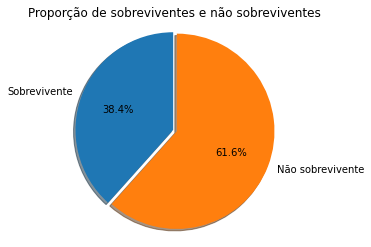

In [ ]:
labels = ["Sobrevivente", "Não sobrevivente"]
size = [sum(y_tr == 1.), sum(y_tr == 0.)]
explode = [0.02, 0.02]

fig, ax1 = plt.subplots()

ax1.pie(size, explode=explode, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis("equal")
plt.title("Proporção de sobreviventes e não sobreviventes")
plt.show()

Mediante o gráfico de setores acima nota-se que a variável dependente encontra-se desbalanceada, ou seja, possui-se um número maior de registros de pessoas que morreram no acidente do navio Titanic do que sobreviveram. Destaca-se, entretanto, que embora haja desbalanceamento, a desproporcionalidade não é tão alta.

#### Análise exploratória, Estatística Descritiva e PCA

Tem-se, a seguir, a visualização dos dados em um espaço bidimensional. Para obter esse resultado, utilizou-se da técnica de análise multivariada PCA (*Principal Component Analysis*). Tal metodologia consiste em construir novas variáveis de tal forma que sejam não correlacionadas entre si e que sejam combinações lineares das variáveis originais. Nesse caso em específico o interesse consiste em encontrar as duas variáveis que mais explicam a variabilidade existente nos atributos.

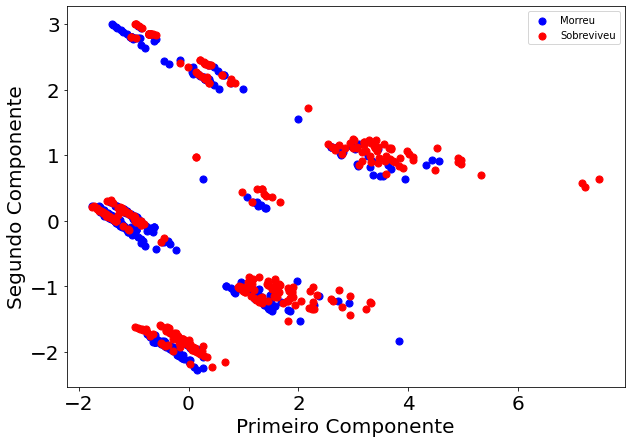

In [ ]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_tr)

classes = np.unique(y_tr)

colors = ['b', 'r']
aux = 0
plt.figure(figsize=(10,7))
for c in classes:
    if c == 1:
        lb = 'Sobreviveu'
    else:
        lb = 'Morreu'
    nodes = np.where(y_tr == c)
    plt.scatter(pca_result[nodes,0], pca_result[nodes,1], s=50, color = colors[aux], label = lb)
    aux = aux + 1
plt.legend()
plt.xlabel("Primeiro Componente", fontsize=20)
plt.ylabel("Segundo Componente", fontsize=20)
plt.xticks(color='k', size=20)
plt.yticks(color='k', size=20)
plt.show(True)

Mediante o gráfico de dispersão acima, cujos eixos são as duas componentes principais de maior explicação da matrix de variancia e covariancia estimadas das variáveis independentes, nota-se que os dados não possuem uma separação clara, consideradas as duas dimensões.

Ainda, por meio da técnica PCA, é possível ter um ranqueamento dos atributos que mais explicam a variância dos dados, o que é feito a seguir.

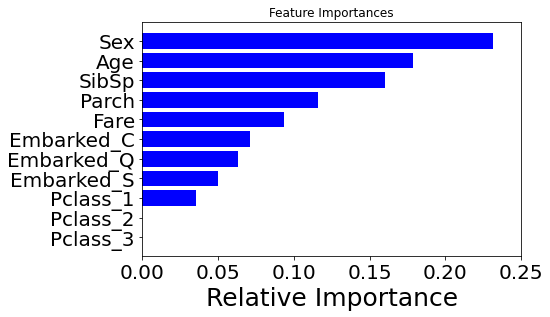

In [ ]:
pca = PCA()
pca_result = pca.fit_transform(X_tr)
var_exp = pca.explained_variance_ratio_

importances = var_exp
attributes = train_titanic.columns[1:len(train_titanic.columns)]
indices = np.argsort(importances)
attributes_rank = []
for i in indices:
    attributes_rank.append(attributes[i])
plt.title('Feature Importances')
plt.tight_layout()
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), attributes_rank, fontsize=25)
plt.xlabel('Relative Importance',fontsize=25)
plt.xticks(color='k', size=20)
plt.yticks(color='k', size=20)
plt.xlim([0.0, 0.25])
plt.show()

Depreende-se da figura acima que o sexo, a idade e quantidade de irmãos e cônjuges a bordo são os atributos mais importantes. Os atributos *Pclass_1*, *Pclass_2* e *Pclass_3* não ajudam a explicar a variância nos dados.

É interessante verificar, portanto, se esses atributos possuem, de fato, alguma relação com a sobrevivência ou não sobrevivência dos passageiros. Começando pelo sexo, tem-se:

In [ ]:
train_titanic[["Sex", "Survived"]].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

Sex  Survived
0    0  0.742038
1    1  0.188908

Logo, a importância do atributo *Sex* se confirma: $74.2\%$ dos sobreviventes eram mulheres, enquanto apenas $18.89\%$ dos sobreviventes eram homens.

A seguir o atributo *Age* será analisado.

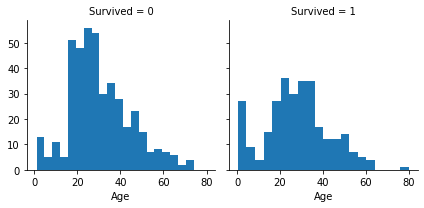

In [ ]:
g = sns.FacetGrid(train_titanic_miss_age, col='Survived')
g.map(plt.hist, 'Age', bins=20)

Através do gráfico acima é possível concluir que a idade é, de fato, um fator relevante. Ao se analisar o mesmo mais minuciosamente, é possível tirar algumas conclusões, como:

  1. Crianças com idade <= 4 tem alto índice de sobrevivência;
  2. Idosos com idade  >= 80 sobreviveram;
  3. Uma generosa parcela dos tripulantes com idade > 15 e < 25 não sobreviveu;
  4. A maior parte dos passageiros tinha de 15 a 35 anos de idade -- de fato, a idade média obtida é de aproximadamente 30 anos.
    
Ao analisar o atributo referente à quantidade de irmãos e cônjuges a bordo tem-se:

In [ ]:
train_titanic[["SibSp", "Survived"]].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

SibSp  Survived
1      1  0.535885
2      2  0.464286
0      0  0.345395
3      3  0.250000
4      4  0.166667
5      5  0.000000
6      8  0.000000

De fato, percebe-se uma tendência de que quanto menor a quantidade de cônjuges e irmãos a bordo, maior o índice de sobrevivência. 

Agora, voltando ao PCA, vê-se como a variância muda de acordo com o número de componentes: 

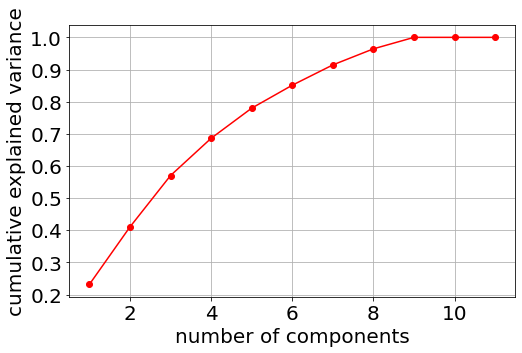

In [ ]:
pca = PCA().fit(X_tr)
plt.figure(figsize=(8,5))
ncomp = np.arange(1, np.shape(X_tr)[1]+1)
plt.plot(ncomp, np.cumsum(pca.explained_variance_ratio_), 'ro-')
plt.xlabel('number of components', fontsize=20)
plt.ylabel('cumulative explained variance', fontsize=20);
plt.xticks(color='k', size=20)
plt.yticks(color='k', size=20)
plt.grid(True)
plt.show(True)

O gráfico acima apresenta a soma acumulada da proporção explicada por cada componente principal, estando a proporção em ordem descrescente. Nesse sentido, pode-se ver que 7 componentes principais explicam cerca de 90% da matriz de variância e covariância estimada dos atributos.

Abaixo tem-se o a análise da correlação entre atributos.

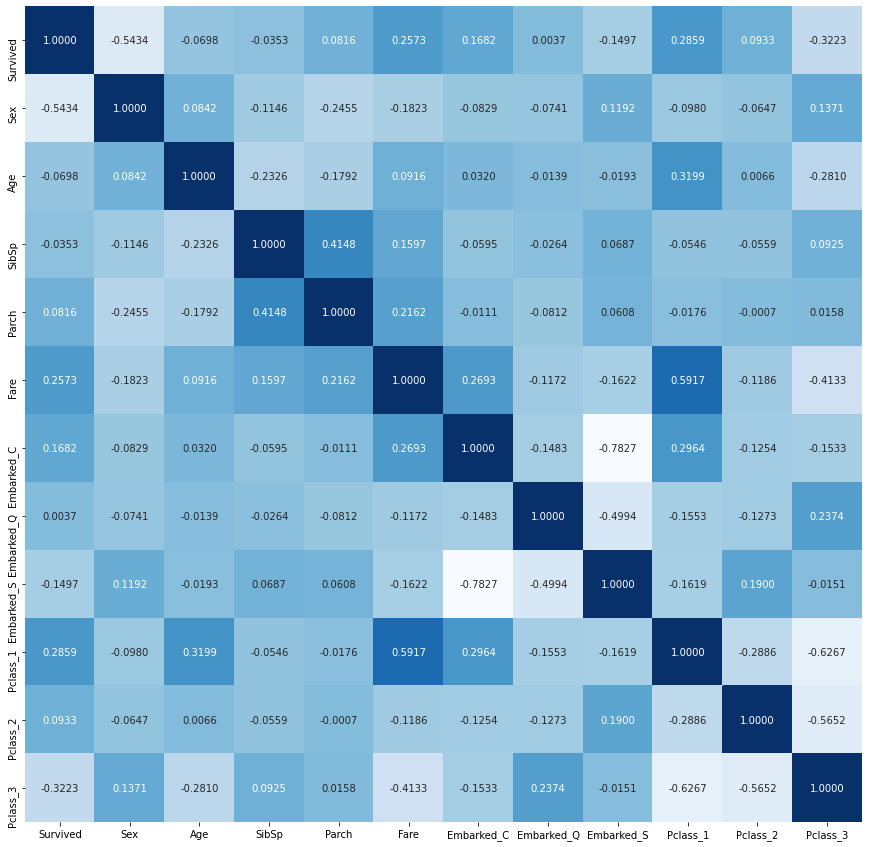

In [ ]:
dados1 = train_titanic.copy()

plt.figure(figsize=(15, 15))
corr = np.corrcoef(dados1.values, rowvar=False)
sns.heatmap(corr, annot=True, cmap='Blues', fmt='.4f', cbar=False, xticklabels=dados1.columns, yticklabels=dados1.columns)
plt.show()

Da figura acima se conclui que nenhum par de atributos não binários possuei forte correlação linear. 

Vê-se, ainda, que o atributo *Embarked_C* possui uma correlação negativa com o atributo *Embarked_S* acima de 70%. Todavia, devido ao fato de que tais atributos são dicotômicos, o coeficiente de correlação linear de Pearson não é o mais adequado. Ainda assim, pode-se atribuir essa forte correlacão negativa ao fato de que as colunas *Embarked_C*, *Embarked_Q* e *Embarked_S* deviram de uma mesma coluna de atributos (*Embarked*). 

Abaixo tem-se o gráfico de dispersão apenas para os atributos contínuos e as covariáveis fruto de contagem.

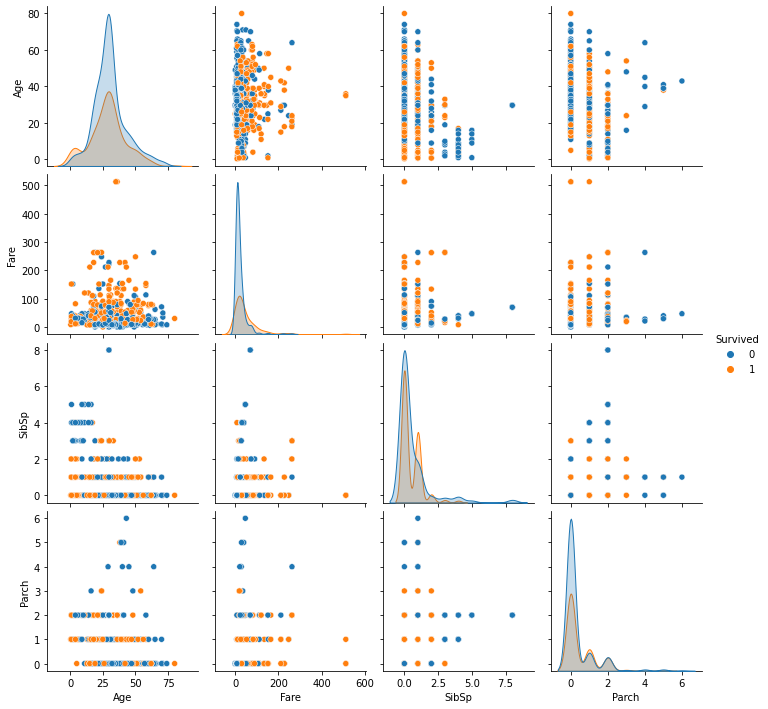

In [ ]:
sns.pairplot(train_titanic.loc[:, ["Survived", "Age",	"Fare", "SibSp", 	"Parch"]], hue="Survived")
plt.show()

Nos gráficos de dispersão acima não é possível observar uma clara sepação nos dados. O mesmo ocorre para os gráficos de estimativa não paramétrica baseada em kernel pra os atributos, localizados na diagonal principal: não se percebe uma separação das densidades quando extratificadas pelas classes da variável resposta.

#### Classificação

##### Stratified k-fold, grid search e cross validation

Definindo função responsável pelo stratified kfold, grid search e cross validation.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

# Args: n_folds = cv folds externos, k_folds = cv folds internos, 
# model = modelo base, p_grid = parametros do modelo para grid search
def strat_kfold_and_crossvalid(X_, y_, model, p_grid, nclas, n_folds = 5, k_folds = 10):
  X = X_.copy()
  y = y_.copy()

  # define cv externo
  cv_outer = StratifiedKFold(n_folds, shuffle=True)
  test_acc_results = list()
  v = []

  # loop CV externo 
  for train_i, test_i in cv_outer.split(X, y):
    # usa indices para pegar os dados efetivamente
      train_x, train_y = X[train_i], y[train_i]
      test_x, test_y = X[test_i], y[test_i]

      # cross validation interno (variando conjunto de validação) 
      grid_search_cv = GridSearchCV(model, p_grid, cv=k_folds, 
                                    scoring='accuracy', refit=True)
      result = grid_search_cv.fit(train_x, train_y)

      # retreina melhor modelo  com (treino + validação)
      best_model = result.best_estimator_

      # faz a previsão no fold de teste 
      pred_y = best_model.predict(test_x) 

      # evaluate and store the results
      print('Accuracy:', accuracy_score(test_y, pred_y))

      if nclas == "rf":
        v.append(best_model.feature_importances_)
        return v

##### Modelo Random Forest

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score 


# Definindo o classificador florestas aleatórias
def class_random_forest(x_tr, y_tr, x_tes, grid_params):
  X_ = x_tr.copy()
  y_ = y_tr.copy()
  X_tes = x_tes.copy()

  gs = GridSearchCV(
      RandomForestClassifier(),
      grid_params,
      verbose = 0, #don't print progress
      cv = 5, #cross validation
      n_jobs = -1 #to use all processors
  )

  gs_results = gs.fit(X_, y_)

  # Usando os melhores parâmetros encontrados:
  model = RandomForestClassifier(n_estimators = gs_results.best_params_['n_estimators'], max_features = gs_results.best_params_['max_features'], 
                                 max_depth = gs_results.best_params_['max_depth'], criterion = gs_results.best_params_['criterion'])
  
  # Ajuste do modelo
  model.fit(X_, y_)


  print('\nFlorestas aleatórias:\n')
  print('       Melhores parâmetros:', gs_results.best_params_)

  # Predizendo conjunto de treino
  pred_values_tr = model.predict(X_)

  # Calculando métricas
  print('       Métricas para o conjunto de treinamento: ')
  print('              Acurácia:           ', accuracy_score(y_, pred_values_tr))
  print('              Precisão:           ', precision_score(y_, pred_values_tr))
  print('              Recall:             ', precision_score(y_, pred_values_tr))
  print('              AUC:                ', roc_auc_score(y_, pred_values_tr))


  # Predizendo conjunto de teste para Kaggle
  pred_values_test = model.predict(X_tes)

  return pred_values_test

###### Classificação: Random Forest sem Feature Selection

Classificando:

In [ ]:
# Optamos por otimizar apenas os parâmetros principais. Sabemos que existem outros parâmetros.
grid_params = {
    'n_estimators': [int(x) for x in np.linspace(100, 1000, num = 5)], # número de árvores na floresta
    'max_features': ['auto', 'sqrt'],  # número máximo de features consideradas para fazer split em um nó
    'max_depth': [int(x) for x in np.linspace(10, 110, num = 5)], # quanto mais profundo sa árvores, mais complexo o modelo
                                                                  # e maior a tendencia à overfitting. 
    'criterion' :['gini','entropy']
}

model = RandomForestClassifier()

v = strat_kfold_and_crossvalid(X_ = X_tr, y_ = y_tr, model = model, p_grid = grid_params, nclas = "rf",
                          n_folds = 2, k_folds = 5)


rf_pred_values = class_random_forest(x_tr= X_tr, y_tr = y_tr, x_tes = X_te, grid_params = grid_params)

Accuracy: 0.7645739910313901
Accuracy: 0.8
Florestas aleatórias:

       Melhores parâmetros: {'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100}
       Métricas para o conjunto de treinamento: 
              Acurácia:            0.9506172839506173
              Precisão:            0.9745222929936306
              Recall:              0.9745222929936306
              AUC:                 0.9400824465535423


Falta, portanto, salvar a predição obtida em um arquivo *csv*, submeter na plataforma Kaggle e coletar os resultados. Isso é feito a seguir.

In [ ]:
# Definindo uma função para tal tarefa
def results_to_csv(pred_values, passengerID_test):
  # Transformando o dataframe com valores preditos em vetor
  y_pred = np.array(pred_values, dtype = int)

  # Criando um dataframe para os dados a serem salvos no arquivo
  prediction = pd.DataFrame()

  # Salvando o id do passageiro e a predição (se sobreviveu ou não) no dataframe
  prediction['PassengerId'] = passengerID_test
  prediction['Survived'] = y_pred

  # Passando para um arquivo csv
  prediction.to_csv('titanic_final.csv', index = False)

In [ ]:
results_to_csv(pred_values = rf_pred_values, passengerID_test = passengerID_test)

Após a submissão do arquivo no Kaggle, obteu-se um score de $0.77990$.

###### Classificação: Random Forest com Feature Selection

Definindo função responsável pelo feature importance (destinada para o classificador Random Forest).

In [ ]:
def feature_importance_rf(v):
    v = np.array(v)
    v = np.mean(v,axis = 0)
    v = v/np.sum(v)

    importances = v
    attributes = train_titanic.columns[1:len(train_titanic.columns)]
    indices = np.argsort(importances)
    attributes_rank = []

    for i in indices:
        attributes_rank.append(attributes[i])

    plt.figure(figsize=(5,10))
    plt.title('Feature Importances')
    plt.tight_layout()
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), attributes_rank, fontsize=25)
    plt.xlabel('Relative Importance',fontsize=25)
    plt.xticks(color='k', size=20)
    plt.yticks(color='k', size=20)
    #plt.xlim([0.0, 0.25])
    plt.show()

Definindo parâmetros para o *grid search* e visualizando as importâncias obtidas:

Accuracy: 0.8094170403587444
Accuracy: 0.8157303370786517



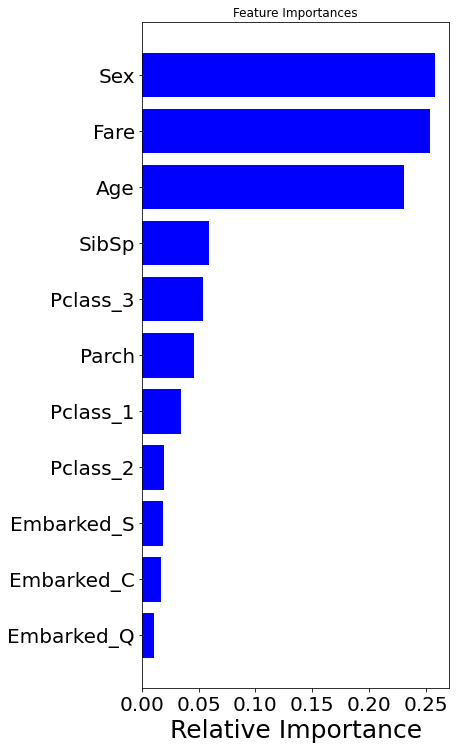

In [ ]:
# Optamos por otimizar apenas os parâmetros principais. Sabemos que existem outros parâmetros.
grid_params = {
    'n_estimators': [int(x) for x in np.linspace(100, 1000, num = 5)], # número de árvores na floresta
    'max_features': ['auto', 'sqrt'],  # número máximo de features consideradas para fazer split em um nó
    'max_depth': [int(x) for x in np.linspace(10, 110, num = 5)], # quanto mais profundo sa árvores, mais complexo o modelo
                                                                  # e maior a tendencia à overfitting. 
    'criterion' :['gini','entropy']
}

model = RandomForestClassifier()

v = strat_kfold_and_crossvalid(X_ = X_tr, y_ = y_tr, model = model, p_grid = grid_params, nclas = "rf",
                          n_folds = 2, k_folds = 5)

print()

# Visualizando feature importance
feature_importance_rf(v)

Como é possível observar, as variáveis *Embarked_S*, *Embarked_C* e *Embarked_Q* são as que apresentam menor importância relativa. Logo, optar-se-á por removê-las para, por fim, performar a classificação através do *Random Forest*. 

In [ ]:
rf_pred_values = class_random_forest(x_tr= X_tr[:, [0, 1, 2, 3, 4, 8, 9, 10]], y_tr = y_tr, x_tes = X_te[:, [0, 1, 2, 3, 4, 8, 9, 10]],
                                     grid_params = grid_params)


Florestas aleatórias:

       Melhores parâmetros: {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 775}
       Métricas para o conjunto de treinamento: 
              Acurácia:            0.9371492704826038
              Precisão:            0.9554140127388535
              Recall:              0.9554140127388535
              AUC:                 0.9258460358546641


Finalmente, passando para um *csv* no formato esperado pelo *Kaggle*:

In [ ]:
results_to_csv(pred_values = rf_pred_values, passengerID_test = passengerID_test)

Após a submissão do arquivo no Kaggle, obteu-se um score de $0.76555$.

##### Modelo Regressão Logística

Destaca-se que na regressão regressão logístiva não foi tomada nunhuma transformação nos dados, isto é, eles não foram padronizados nem normalizados, uma vez que, para a regressão logística essas transformações não são necessárias.

Definindo o modelo:

In [ ]:
from sklearn.linear_model import LogisticRegression

def class_rl(x_tr, y_tr, x_tes):
  X_ = x_tr.copy()
  y_ = y_tr.copy()
  X_tes = x_tes.copy()  
 

  # Ajuste do modelo
  model = LogisticRegression(max_iter= 1000)
  model.fit(X_, y_)


  print('\nRegressão logística:\n')

  # Predizendo conjunto de treino
  pred_values_tr = model.predict(X_)

  # Calculando métricas
  print('       Métricas para o conjunto de treinamento: ')
  print('              Acurácia:           ', accuracy_score(y_, pred_values_tr))
  print('              Precisão:           ', precision_score(y_, pred_values_tr))
  print('              Recall:             ', precision_score(y_, pred_values_tr))
  print('              AUC:                ', roc_auc_score(y_, pred_values_tr))


  # Predizendo conjunto de teste para Kaggle
  pred_values_test = model.predict(X_tes)

  return pred_values_test

###### Classificação: Regressão Logística sem Feature Selection

Abaixo tem-se a validação cruzada para o classificador, para isso utiliza-se para isso o StratifiedKFold (vide o desbalanceamento dos dados).

In [ ]:
X = train_titanic.iloc[:, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]].to_numpy()
y = train_titanic.iloc[:, 0].to_numpy()

# define cv externo
cv_outer = StratifiedKFold(10, shuffle=True)
test_acc_results = list()
acc = []

# loop CV externo 
for train_i, test_i in cv_outer.split(X, y):
    # usa indices para pegar os dados efetivamente
    train_x, train_y = X[train_i], y[train_i]
    test_x, test_y = X[test_i], y[test_i]

    model = LogisticRegression(max_iter=1000)
    model.fit(train_x, train_y)

    # faz a previsão no fold de teste 
    pred_y = model.predict(test_x) 

    # evaluate and store the results
    print('Accuracy:', accuracy_score(test_y, pred_y))
    acc.append(accuracy_score(test_y, pred_y))
  
print("\nAcurácia Média:", np.mean(acc))
print("\nDesvio Padrão da acurácia:", np.std(acc, ddof=1), "\n")

Accuracy: 0.8333333333333334
Accuracy: 0.7528089887640449
Accuracy: 0.8089887640449438
Accuracy: 0.8089887640449438
Accuracy: 0.8202247191011236
Accuracy: 0.8539325842696629
Accuracy: 0.7865168539325843
Accuracy: 0.7752808988764045
Accuracy: 0.8314606741573034
Accuracy: 0.7528089887640449

Acurácia Média: 0.802434456928839

Desvio Padrão da acurácia: 0.03458932118792397 



Chamando a função para efetuar a classificação:

In [ ]:
rf_pred_values = class_rl(x_tr = train_titanic.iloc[:, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]].to_numpy(), 
                          y_tr = train_titanic.iloc[:, 0].to_numpy(), x_tes = test_titanic.to_numpy())


Regressão logística:

       Métricas para o conjunto de treinamento: 
              Acurácia:            0.8058361391694725
              Precisão:            0.7717041800643086
              Recall:              0.7717041800643086
              AUC:                 0.786214169303039


Passando para um *csv* no formato esperado pelo *Kaggle*:

In [ ]:
results_to_csv(pred_values = rf_pred_values, passengerID_test = passengerID_test)

Após a submissão do arquivo no Kaggle, obteu-se um score de $0.77272$.

###### Classificação: Regressão Logística com Feature Selection

Definindo código responsável pelo feature importance (destinada para o classificador Regressão Logística) e executando-o:

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

#apply SelectKBest class to extract top 10 best features
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(train_titanic.iloc[:, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]], train_titanic.iloc[:, 0])

dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(train_titanic.iloc[:, [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]].columns)

#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns

print(featureScores.nlargest(10,'Score'))  #print 10 best features

         Specs        Score
4         Fare  4518.319091
0          Sex    92.702447
8     Pclass_1    55.175151
10    Pclass_3    41.553071
1          Age    24.687926
5   Embarked_C    20.464401
3        Parch    10.097499
9     Pclass_2     6.160767
7   Embarked_S     5.489205
2        SibSp     2.581865


Destaca-se que o *score* acima é calculado com base nas estatísticas Qui-Quadrado entre cada atributo (não negativo) e a variável resposta. Lembre-se de que o teste do Qui-Quadrado mede, entre outras aplicações, a dependência entre as variáveis ​​estocásticas e, portanto, o uso dessa função "elimina" (ou pelo menos tenta evidenciar) os atributos que têm maior probabilidade de serem independentes da variável resposta e, nesse sentido, irrelevantes para a classificação.

Como é possível observar, os atributos mais importantes para o modelo são *Fare*, *Sex*, *Pclass_1*, *Pclass_3* e *Age*. Os mesmos serão, portanto, utilizados para a classificação com Regressão Logística.

Em seguida, tem-se a validação cruzada para o referido classificador. Utiliza-se para isso o StratifiedKFold (vide o desbalanceamento dos dados).

In [ ]:
X = train_titanic.iloc[:, [1, 2, 5, 9, 11]].to_numpy()
y = train_titanic.iloc[:, 0].to_numpy()

# define cv externo
cv_outer = StratifiedKFold(10, shuffle=True)
test_acc_results = list()
acc = []

# loop CV externo 
for train_i, test_i in cv_outer.split(X, y):
    # usa indices para pegar os dados efetivamente
    train_x, train_y = X[train_i], y[train_i]
    test_x, test_y = X[test_i], y[test_i]

    model = LogisticRegression(max_iter=1000)
    model.fit(train_x, train_y)

    # faz a previsão no fold de teste 
    pred_y = model.predict(test_x) 

    # evaluate and store the results
    print('Accuracy:', accuracy_score(test_y, pred_y))
    acc.append(accuracy_score(test_y, pred_y))
  
print("\nAcurácia Média:", np.mean(acc))
print("\nDesvio Padrão da acurácia:", np.std(acc, ddof=1), "\n")

Accuracy: 0.8
Accuracy: 0.8539325842696629
Accuracy: 0.7865168539325843
Accuracy: 0.797752808988764
Accuracy: 0.7865168539325843
Accuracy: 0.7640449438202247
Accuracy: 0.8314606741573034
Accuracy: 0.7865168539325843
Accuracy: 0.7640449438202247
Accuracy: 0.7528089887640449

Acurácia Média: 0.7923595505617977

Desvio Padrão da acurácia: 0.031051377157828602 



In [ ]:
rf_pred_values = class_rl(x_tr = train_titanic.iloc[:, [1, 2, 5, 9, 11]].to_numpy(), 
                          y_tr = train_titanic.iloc[:, 0].to_numpy(), x_tes = test_titanic.iloc[:, [0, 1, 4, 8, 10]].to_numpy())


Regressão logística:

       Métricas para o conjunto de treinamento: 
              Acurácia:            0.797979797979798
              Precisão:            0.753125
              Recall:              0.753125
              AUC:                 0.7803901831080433


Passando para um *csv* no formato esperado pelo *Kaggle*:

In [ ]:
results_to_csv(pred_values = rf_pred_values, passengerID_test = passengerID_test)

Após a submissão do arquivo no Kaggle, obteu-se um score de $0.75837$.

##### Modelo SVM

Definindo o modelo:

In [ ]:
from sklearn import svm

def class_svm(x_tr, y_tr, x_tes, grid_params):
  X_ = x_tr.copy()
  y_ = y_tr.copy()
  X_tes = x_tes.copy()  

  gs = GridSearchCV(
      svm.SVC(),
      grid_params,
      verbose = 0, #don't print progress
      cv = 5, #cross validation
      n_jobs = -1 #to use all processors
  )

  gs_results = gs.fit(X_, y_)

  # Usando os melhores parâmetros encontrados:
  model = svm.SVC(kernel = gs_results.best_params_['kernel'], C = gs_results.best_params_['C'], 
                                 gamma = gs_results.best_params_['gamma'])
  
  # Ajuste do modelo
  model.fit(X_, y_)


  print('\nSVM:\n')
  print('       Melhores parâmetros:', gs_results.best_params_)

  # Predizendo conjunto de treino
  pred_values_tr = model.predict(X_)

  # Calculando métricas
  print('       Métricas para o conjunto de treinamento: ')
  print('              Acurácia:           ', accuracy_score(y_, pred_values_tr))
  print('              Precisão:           ', precision_score(y_, pred_values_tr))
  print('              Recall:             ', precision_score(y_, pred_values_tr))
  print('              AUC:                ', roc_auc_score(y_, pred_values_tr))


  # Predizendo conjunto de teste para Kaggle
  pred_values_test = model.predict(X_tes)

  return pred_values_test

###### Classificação: SVM

Classificando:

In [ ]:
# Optamos por otimizar apenas os parâmetros principais. Sabemos que existem outros parâmetros.
grid_params = {
    'C': [int(x) for x in np.linspace(1, 100, num = 5)], 
    'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  
    'gamma': ['auto', 'scale'] 
}

model = svm.SVC()

v = strat_kfold_and_crossvalid(X_ = X_tr, y_ = y_tr, model = model, p_grid = grid_params, nclas = "svm",
                          n_folds = 2, k_folds = 5)


rf_pred_values = class_svm(x_tr = X_tr, y_tr = y_tr, x_tes = X_te, grid_params = grid_params)

Accuracy: 0.7713004484304933
Accuracy: 0.802247191011236

SVM:

       Melhores parâmetros: {'C': 1, 'gamma': 'auto', 'kernel': 'poly'}
       Métricas para o conjunto de treinamento: 
              Acurácia:            0.8305274971941639
              Precisão:            0.899581589958159
              Recall:              0.899581589958159
              AUC:                 0.7924695618828492


Salvar a predição obtida em um arquivo *csv*, para submeter na plataforma Kaggle e coletar os resultados:

In [ ]:
results_to_csv(pred_values = rf_pred_values, passengerID_test = passengerID_test)

Após a submissão do arquivo no Kaggle, obteu-se um score de $0.77272$.